In [ ]:
import main
import warnings
import itertools
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
warnings.filterwarnings("ignore")
from prophet import Prophet
from tqdm import tqdm

from statsmodels.tsa.api import Holt
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

Importing plotly failed. Interactive plots will not work.


--------------------------------------------------------------------------------------

Precipitações atmosféricas anuais em **Fortaleza**, CE, de 1849 a 1997

In [ ]:
data1 = pd.read_excel('https://www.ime.usp.br/~pam/fortaleza.xls',parse_dates=True, index_col='Ano')

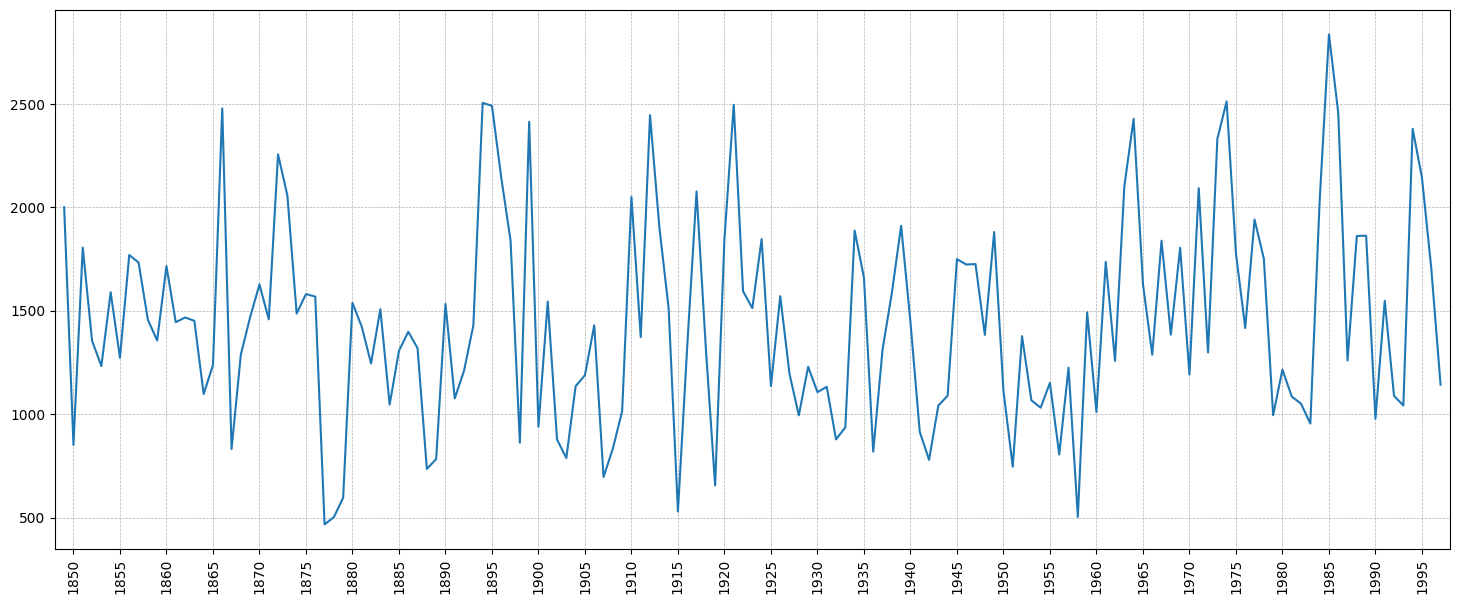

In [ ]:
plt.figure(figsize=(18, 7))
plt.plot(data1['Fort'])
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=5))

plt.xlim(pd.Timestamp('1848-01-01'), pd.Timestamp('1998-01-01'))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adicionando título e legendas aos eixos
plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)

plt.show()

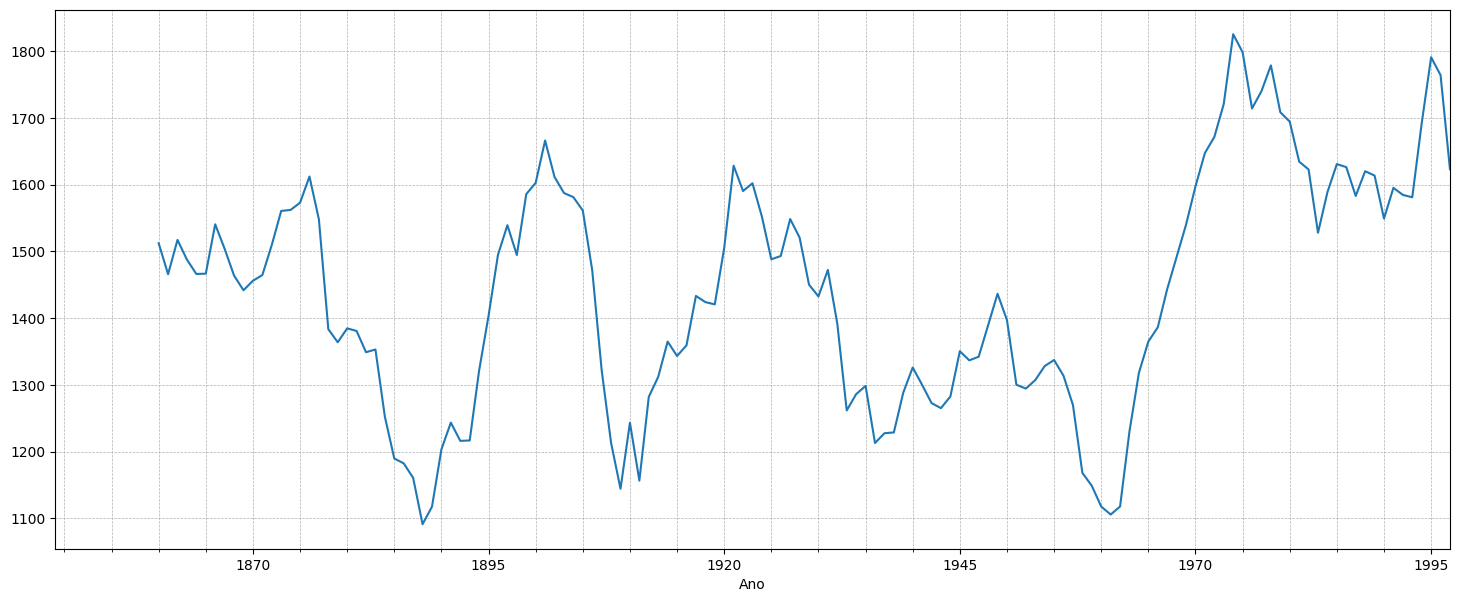

In [ ]:
data1['Fort'].rolling(12).mean().plot(figsize=(18, 7))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# Adicionando título e legendas aos eixos
plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.show()

- Após conduzir uma análise de tendência, concluiu-se que a série temporal não exibe nenhum padrão ou tendência discernível.

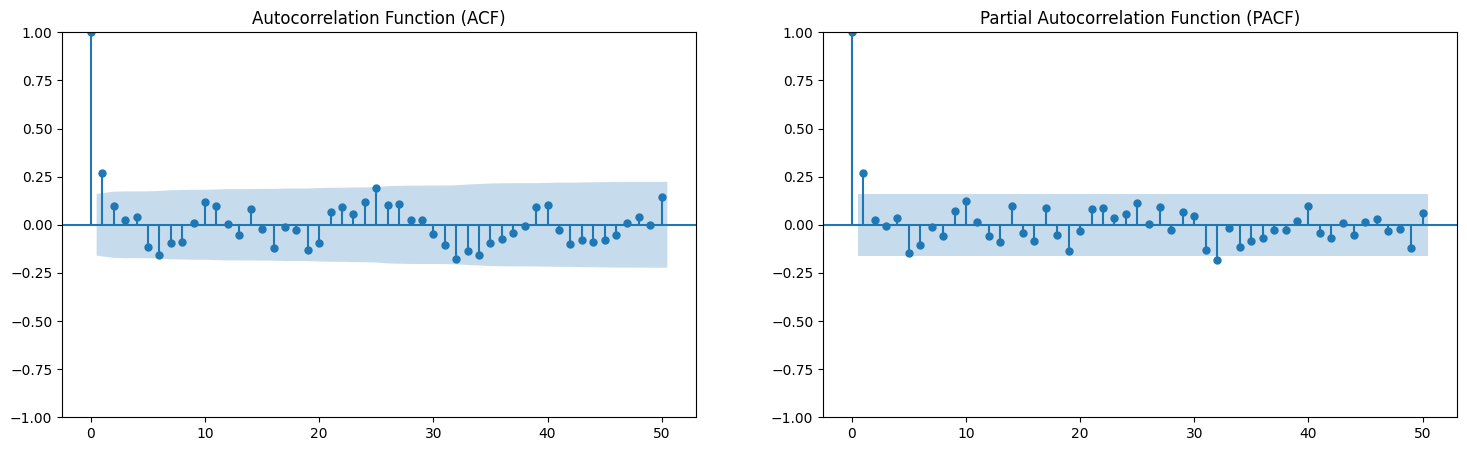

In [ ]:
main.data1_acf_pacf()

In [ ]:
result = adfuller(data1['Fort'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key,value))

ADF Statistic: -9.174584
p-value: 0.000000
Critical Values:
	1%: -3.475
	5%: -2.881
	10%: -2.577


- Ao constatar a ausência de tendência na série e ao conduzir análises visuais do ACF e do PACF, juntamente com a aplicação do teste de Dickey-Fuller, todas as quatro avaliações convergem para a conclusão de que a série temporal é estacionária.

- ARIMA

In [ ]:
threshold = int(0.8*len(data1))
train_set = data1[:threshold]
test_set = data1[threshold:]

In [ ]:
model = ARIMA(train_set['Fort'], order=(50, 0, 10)).fit()
print('MSE:', (model.resid**2).mean())
print('AIC:', model.aic)

MSE: 139820.2289070166
AIC: 1869.5157043131387


In [ ]:
main.erro(model,test_set)

621.3297016336898

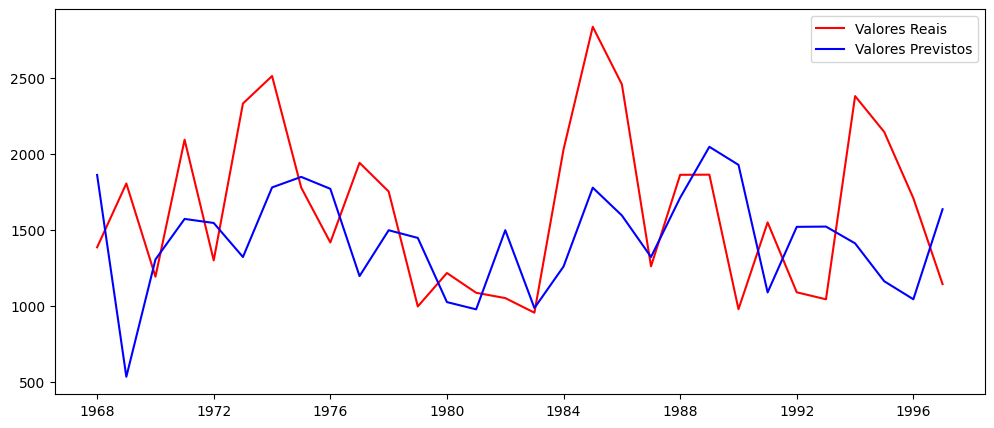

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(test_set['Fort'], color='blue', label='Valores Reais')
plt.plot(model.forecast(30), color='red', label='Valores Previstos')
erro = main.erro(model, test_set)

plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.legend(['Valores Reais', f'Valores Previstos (Erro: {erro})'])
plt.show()

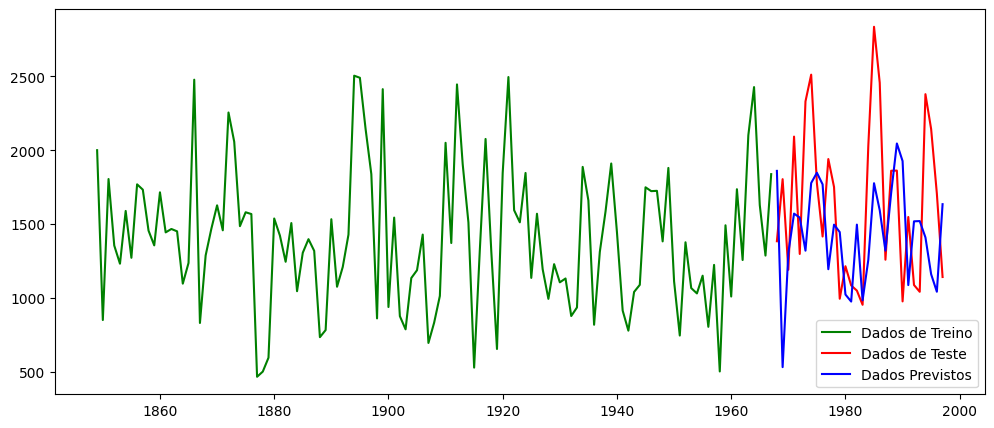

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_set['Fort'],color='green',label='Dados de Treino')
plt.plot(test_set['Fort'],color='blue',label='Dados de Teste')
plt.plot(model.forecast(30), color='red', label='Dados Previstos')
plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.legend()
plt.show()

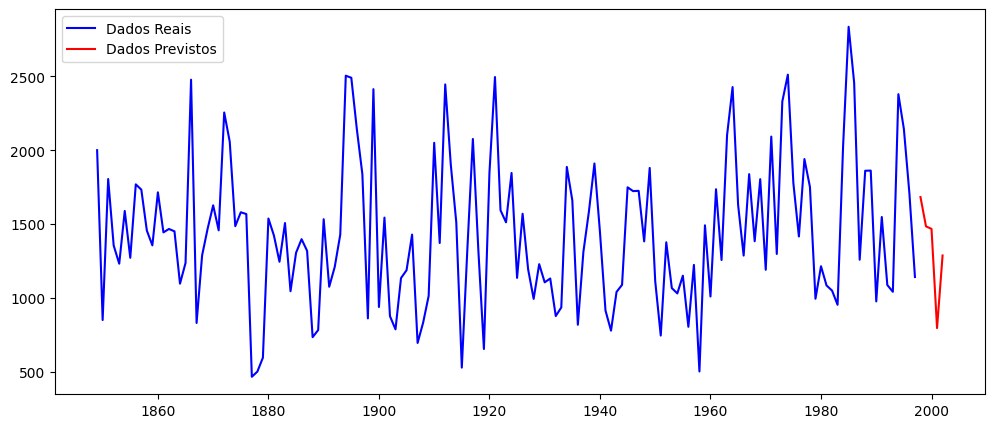

In [ ]:
model = ARIMA(data1['Fort'], order=(50, 0, 10)).fit()
plt.figure(figsize=(12,5))
plt.plot(data1['Fort'],color='blue',label='Dados Reais')
plt.plot(model.forecast(1), color='red', label='Dados Previstos')
plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.legend()
plt.show()

In [ ]:
model = ARIMA(data1['Fort'], order=(50, 0, 10)).fit()

1998-01-01    1684.048128
1999-01-01    1485.712208
2000-01-01    1468.597114
2001-01-01     797.578107
2002-01-01    1288.647377
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [ ]:
forecast_index = pd.Timestamp('1998-01-01')
forecast_value = model.forecast(1)[0]

# Plotagem do gráfico
plt.figure(figsize=(12, 5))
plt.plot(data1['Fort'], color='blue', label='Dados Reais')
plt.plot(forecast_index, forecast_value, 'ro', label=f'Dados Previstos:{str(forecast_index).split()[0]}  -   {forecast_value:.2f}')
plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.legend()
plt.show()

<h2> Suavização Exponencial Simples</h2>

In [ ]:
n = 10 # número de divisões do intervalo [0, 1]
h = 1/n # amplitude de cada intervalo
alphas = []
alpha = h
errors = []
for i in range(n):
  alphas.append(alpha)
  ses = SimpleExpSmoothing(data1['Fort']).fit(smoothing_level=alpha, optimized=False)
  mse = (ses.resid**2).mean()
  errors.append(mse)
  alpha = alpha + h
print('alphas = ',alphas)
print('MSE = ', errors)

alphas =  [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7, 0.7999999999999999, 0.8999999999999999, 0.9999999999999999]
MSE =  [261193.27809931568, 262001.09324938784, 265132.9692354652, 269668.44446510635, 276254.2388036131, 285391.81701904343, 297406.5207888402, 312617.9879899281, 331529.7488268481, 355011.20805369125]


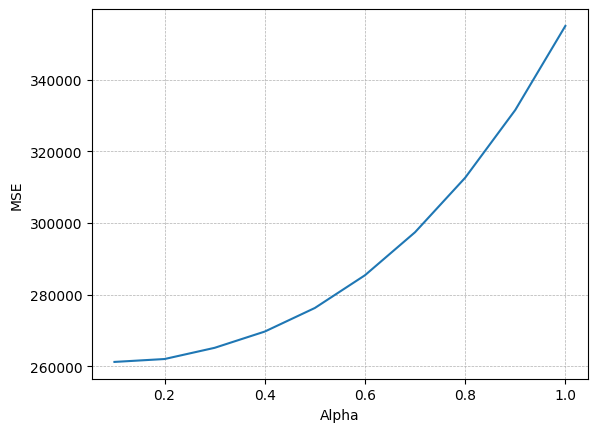

In [ ]:
n = 10 # número de divisões do intervalo [0, 1]
h = 1/n # amplitude de cada intervalo
alphas = []
alpha = h
errors = []
for i in range(n):
  alphas.append(alpha)
  ses = SimpleExpSmoothing(data1['Fort']).fit(smoothing_level=alpha, optimized=False)
  mse = (ses.resid**2).mean()
  errors.append(mse)
  alpha = alpha + h
plt.plot(alphas, errors)
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

Quando menor o valor de suavização, menor será o erro

<h4> Treino-teste para achar o melhor nivel de suavizacao</h4>

In [ ]:
threshold = int(0.8*len(data1['Fort']))
train_set = data1[:threshold]
test_set = data1[threshold:]

In [ ]:
smoot_level = 0.1
menor_mse = float('inf')
melhor_sl = 0
while True:
    if smoot_level >0.95:
        break
    SES = SimpleExpSmoothing(train_set).fit(smoothing_level=smoot_level, optimized=False)
    MSE_Treino = ((SES.resid)**2).mean()
    if MSE_Treino < menor_mse:
        menor_mse = MSE_Treino
        melhor_sl = smoot_level

    MSE_Teste = mean_squared_error(test_set,SES.forecast(len(test_set)))
    print(f'SMOOTHING LEVEL= {round(smoot_level,2)} MSE TREINO: {round(MSE_Treino,2)} MSE TESTE: {round(MSE_Teste,2)}')
    smoot_level+=0.01

print(f'MENOR MSE TREINO={round(menor_mse,2)} MELHOR SL = {round(melhor_sl,2)}')

SMOOTHING LEVEL= 0.1 MSE TREINO: 248814.96 MSE TESTE: 307277.76
SMOOTHING LEVEL= 0.11 MSE TREINO: 248277.16 MSE TESTE: 302390.56
SMOOTHING LEVEL= 0.12 MSE TREINO: 247886.99 MSE TESTE: 298040.14
SMOOTHING LEVEL= 0.13 MSE TREINO: 247599.85 MSE TESTE: 294242.2
SMOOTHING LEVEL= 0.14 MSE TREINO: 247386.4 MSE TESTE: 290987.21
SMOOTHING LEVEL= 0.15 MSE TREINO: 247227.23 MSE TESTE: 288248.89
SMOOTHING LEVEL= 0.16 MSE TREINO: 247109.61 MSE TESTE: 285990.22
SMOOTHING LEVEL= 0.17 MSE TREINO: 247025.28 MSE TESTE: 284167.87
SMOOTHING LEVEL= 0.18 MSE TREINO: 246969.03 MSE TESTE: 282735.49
SMOOTHING LEVEL= 0.19 MSE TREINO: 246937.74 MSE TESTE: 281645.96
SMOOTHING LEVEL= 0.2 MSE TREINO: 246929.64 MSE TESTE: 280853.08
SMOOTHING LEVEL= 0.21 MSE TREINO: 246943.89 MSE TESTE: 280312.8
SMOOTHING LEVEL= 0.22 MSE TREINO: 246980.26 MSE TESTE: 279983.94
SMOOTHING LEVEL= 0.23 MSE TREINO: 247038.87 MSE TESTE: 279828.77
SMOOTHING LEVEL= 0.24 MSE TREINO: 247120.08 MSE TESTE: 279813.23
SMOOTHING LEVEL= 0.25 MSE TREI

Melhor valor encontrado de nível de suavização foi 0.2, considerando o menor MSE no treino e um MSE relativamente baixo comparado com os demais no teste

In [ ]:
SES_final = SimpleExpSmoothing(train_set).fit(smoothing_level=melhor_sl, optimized=False)

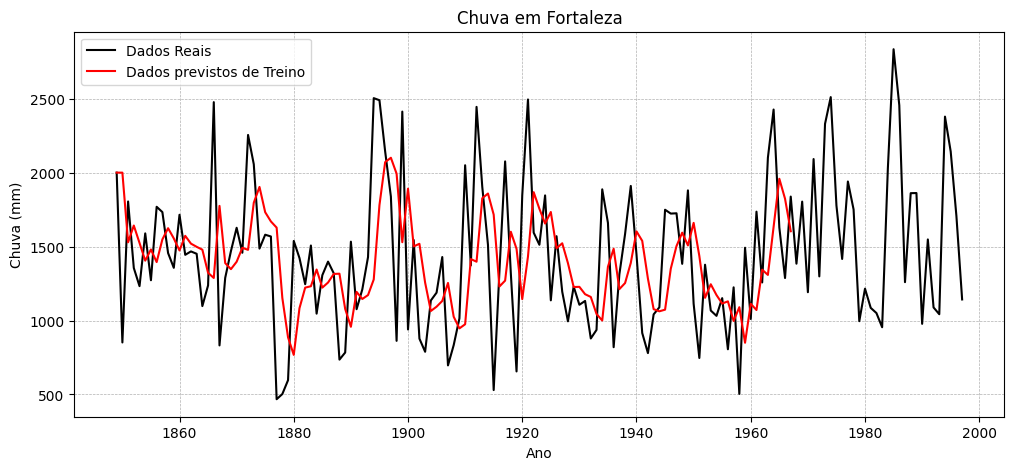

In [ ]:
mse = mean_squared_error(train_set, SES_final.fittedvalues)

plt.figure(figsize=(12,5))
plt.plot(train_set['Fort'], color='black', label='Dados Reais')
plt.plot(SES_final.fittedvalues, color='red', label=f'Dados previstos de Treino - Erro: {mse.round(2)}')
plt.legend()
plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

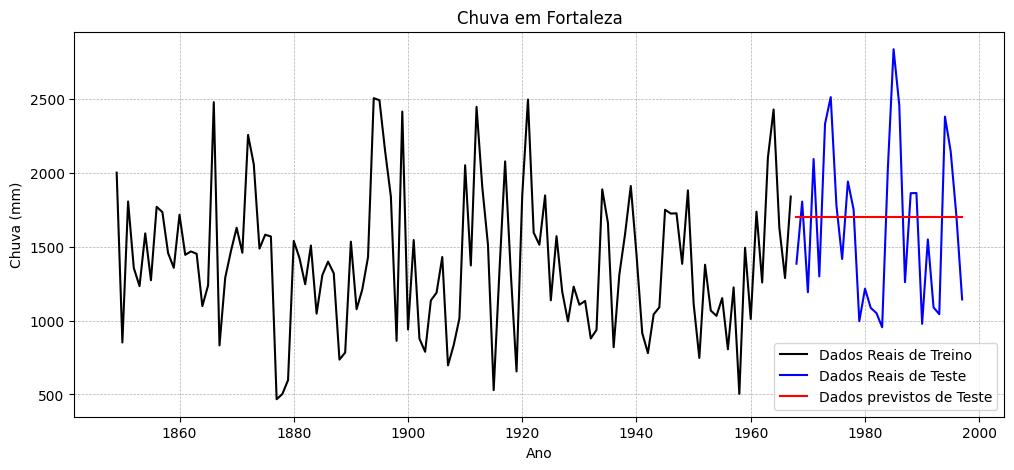

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_set, color='black', label='Dados Reais de Treino')
plt.plot(test_set, color='blue', label='Dados Reais de Teste')
plt.plot(SES_final.forecast(len(test_set)), color='red', label='Dados previstos de Teste')
plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
smoot_level = 0.1
menor_mse = float('inf')
melhor_sl = 0
while True:
    if smoot_level >0.95:
        break
    SES = SimpleExpSmoothing(data1['Fort'].iloc[:-1]).fit(smoothing_level=smoot_level, optimized=False)
    MSE_Treino = ((SES.resid)**2).mean()
    if MSE_Treino < menor_mse:
        menor_mse = MSE_Treino
        melhor_sl = smoot_level

    MSE_Teste = mean_squared_error(data1['Fort'].iloc[:-1],SES.forecast(len(data1['Fort'].iloc[:-1])))
    #print(f'SMOOTHING LEVEL= {round(smoot_level,2)} MSE TREINO: {round(MSE_Treino,2)} MSE TESTE: {round(MSE_Teste,2)}')
    smoot_level+=0.01

#print(f'MENOR MSE TREINO={round(menor_mse,2)} MELHOR SL = {round(melhor_sl,2)}')
SES_final = SimpleExpSmoothing(data1['Fort'].iloc[:-1]).fit(smoothing_level=melhor_sl, optimized=False)

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_set, color='black', label='Dados Reais de Treino')
plt.scatter(test_set.index[0], test_set.iloc[0], color='blue', label='Valor Real')
plt.scatter(test_set.index[0], SES_final.forecast(1), color='red', marker='o', label='Valor Previsto')


x_values = [test_set.index[0], test_set.index[0]]
y_values = [test_set.values[0][0], SES_final.forecast(1).values[0]]
erro = ((SES_final.forecast(1).values[0] - test_set.values[0][0])*2)*(1/2)
plt.plot(x_values, y_values, linestyle='--', color='green', label=f'Erro: {erro.round(2)}')

plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
forecast_index = pd.Timestamp('1998-01-01')


plt.figure(figsize=(12,5))
plt.plot(data1['Fort'], color='black', label='Dados Reais de Treino')

plt.scatter(forecast_index, SES_final.forecast(1), color='red', marker='o', label=f'Valor Previsto:{str(forecast_index).split()[0]}  -  {SES_final.forecast(1)[0].round(2)}')

plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997) - optimized = False', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
print("MSE TESTE ",mean_squared_error(test_set,SES_final.forecast(len(test_set))))
print("RMSE TESTE ",mean_squared_error(test_set,SES_final.forecast(len(test_set)))**(1/2))

MSE TESTE  283688.72446190746
RMSE TESTE  532.6243746411794


In [ ]:
print("MSE TREINO ",mean_squared_error(train_set,SES_final.fittedvalues))
print("RMSE TREINO ",mean_squared_error(train_set,SES_final.fittedvalues)**(1/2))

MSE TREINO  252404.54081796008
RMSE TREINO  502.3987866406129


Apesar de ter um erro no treino bom e parecer estar se adaptando a série original, o modelo não tem nenhuma capacidade de previsão (forecast)

<h4> Suavização Exponencial Simples otimizada (com optimized = True) </h4>

In [ ]:
SES_opt = SimpleExpSmoothing(train_set).fit(optimized=True)

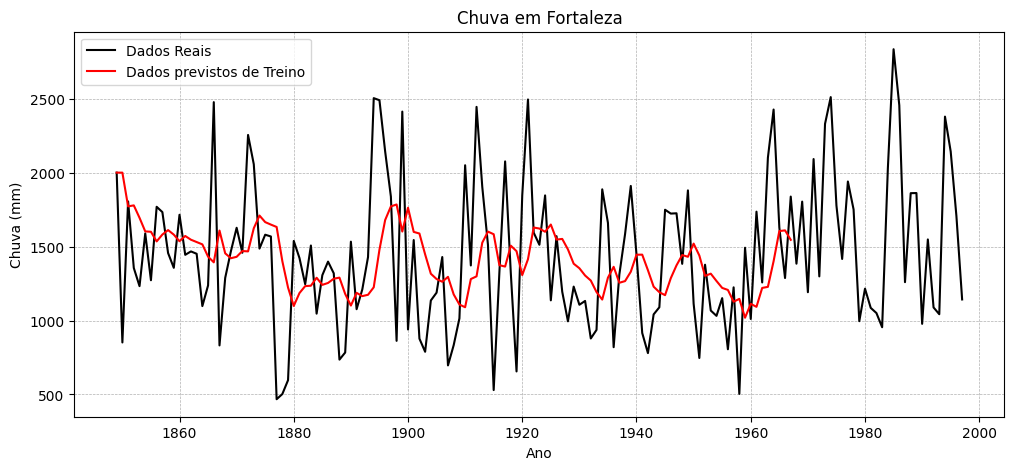

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(data1['Fort'], color='black', label='Dados Reais')
plt.plot(SES_opt.fittedvalues, color='red', label='Dados previstos de Treino')
plt.title('Chuva em Fortaleza')
plt.xlabel('Ano')
plt.ylabel('Chuva (mm)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

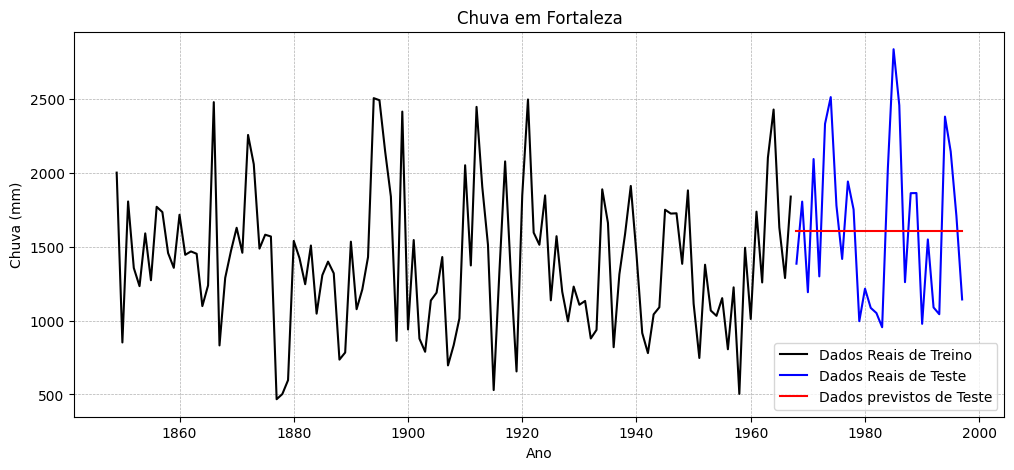

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_set, color='black', label='Dados Reais de Treino')
plt.scatter(test_set.index[0], test_set.iloc[0], color='blue', label='Valor Real')
plt.scatter(test_set.index[0], SES_opt.forecast(1), color='red', marker='o', label='Valor Previsto')


x_values = [test_set.index[0], test_set.index[0]]
y_values = [test_set.values[0][0], SES_opt.forecast(1).values[0]]
erro = ((SES_opt.forecast(1).values[0] - test_set.values[0][0])*2)*(1/2)
plt.plot(x_values, y_values, linestyle='--', color='green', label=f'Erro: {erro.round(2)}')

plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
forecast_index = pd.Timestamp('1998-01-01')


plt.figure(figsize=(12,5))
plt.plot(data1['Fort'], color='black', label='Dados Reais de Treino')

plt.scatter(forecast_index, SES_opt.forecast(1), color='red', marker='o', label=f'Valor Previsto:{str(forecast_index).split()[0]}  -  {SES_opt.forecast(1)[0].round(2)}')

plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997) - optimized = True', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
print(f'MSE TESTE: {mean_squared_error(test_set,SES_opt.forecast(len(test_set)))}')
print(f'RMSE TESTE: {mean_squared_error(test_set,SES_opt.forecast(len(test_set)))**(1/2)}')

MSE TESTE: 280948.79896456125
RMSE TESTE: 530.0460347597756


In [ ]:
print(f'MSE TREINO: {mean_squared_error(train_set,SES_opt.fittedvalues)}')
print(f'RMSE TREINO: {mean_squared_error(train_set,SES_opt.fittedvalues)**(1/2)}')

MSE TREINO: 246929.4132596517
RMSE TREINO: 496.9199264063091


Apesar de ter um erro no treino bom e parecer estar se adaptando a série original, o modelo não tem nenhuma capacidade de previsão (forecast)

<h4> <b> Podemos concluir que suavização exponencial simples não performa bem nesta série devido a incapacidade de previsão e fitting retardado</b></h4>

<h2> Suavização Exponencial de Holt</h2>

In [ ]:
threshold = int(0.8*len(data1['Fort']))
train_set = data1[:threshold]
test_set = data1[threshold:]

In [ ]:
smoot_level = 0.1
smoot_trend = 0.1
menor_mse = float('inf')
melhor_sl = 0
melhor_st = 0
while True:
    print(f'smooth_trend {smoot_trend}')
    if smoot_trend >0.9:
        break
    while True:
        if smoot_level >0.95:
            break
        SEH = Holt(train_set).fit(smoothing_level=smoot_level, smoothing_trend=0.9, optimized=False)
        MSE_Treino = ((SEH.resid)**2).mean()
        if MSE_Treino < menor_mse:
            menor_mse = MSE_Treino
            melhor_sl = smoot_level
            melhor_st = smoot_trend

        MSE_Teste = mean_squared_error(test_set,SEH.forecast(len(test_set)))
        #print(f'SMOOTHING LEVEL= {round(smoot_level,2)} MSE TREINO: {round(MSE_Treino,2)} MSE TESTE: {round(MSE_Teste,2)}')
        smoot_level+=0.01
    smoot_trend +=0.1
    smoot_level = 0


print(f'MENOR MSE TREINO={round(menor_mse,2)} MELHOR SL = {round(melhor_sl,2)} MELHOR ST = {round(melhor_st,2)}')

smooth_trend 0.1
smooth_trend 0.2
smooth_trend 0.30000000000000004
smooth_trend 0.4
smooth_trend 0.5
smooth_trend 0.6
smooth_trend 0.7
smooth_trend 0.7999999999999999
smooth_trend 0.8999999999999999
smooth_trend 0.9999999999999999
MENOR MSE TREINO=423558.78 MELHOR SL = 0.41 MELHOR ST = 0.2


In [ ]:
SEH_final = Holt(train_set).fit(smoothing_level=melhor_sl, smoothing_trend=melhor_st, optimized=False)

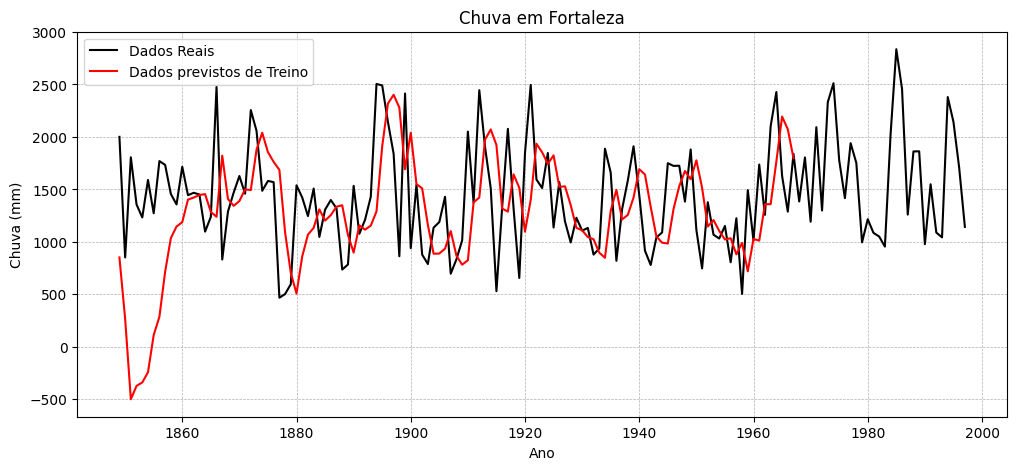

In [ ]:
mse = mean_squared_error(train_set, SEH_final.fittedvalues)

plt.figure(figsize=(12,5))
plt.plot(train_set, color='black', label='Dados Reais')
plt.plot(SEH_final.fittedvalues, color='red', label=f'Dados previstos de Treino - Erro: {mse.round(2)}')
plt.legend()
plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997) - optimized = False', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

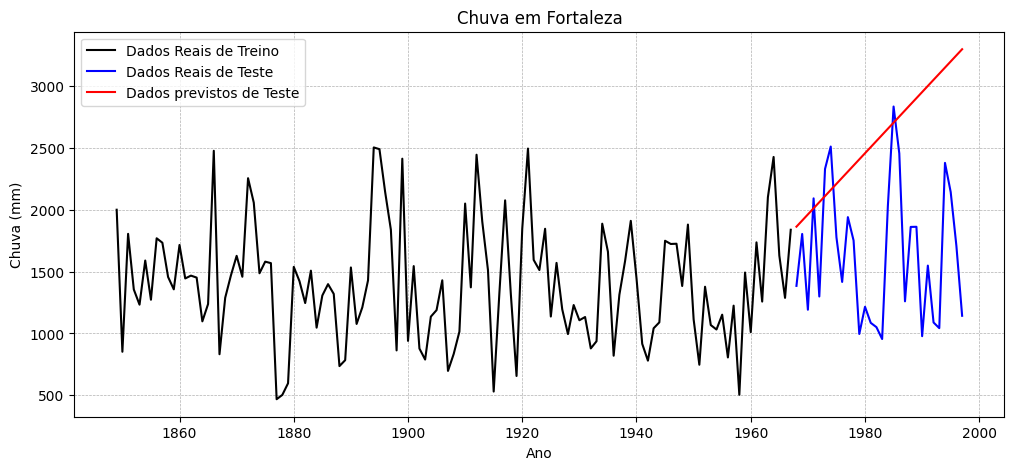

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_set, color='black', label='Dados Reais de Treino')
plt.scatter(test_set.index[0], test_set.iloc[0], color='blue', label='Valor Real')
plt.scatter(test_set.index[0], SEH_final.forecast(1), color='red', marker='o', label='Valor Previsto')


x_values = [test_set.index[0], test_set.index[0]]
y_values = [test_set.values[0][0], SEH_final.forecast(1).values[0]]
erro = ((SEH_final.forecast(1).values[0] - test_set.values[0][0])*2)*(1/2)
plt.plot(x_values, y_values, linestyle='--', color='green', label=f'Erro: {erro.round(2)}')

plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997) - optimized = False', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
print(f'MSE TESTE: {mean_squared_error(test_set,SEH_final.forecast(len(test_set)))}')
print(f'RMSE TESTE: {mean_squared_error(test_set,SEH_final.forecast(len(test_set)))**(1/2)}')

MSE TESTE: 1378328.1662935042
RMSE TESTE: 1174.022217120913


In [ ]:
print(f'MSE TREINO: {mean_squared_error(train_set,SEH_final.fittedvalues)}')
print(f'RMSE TREINO: {mean_squared_error(train_set,SEH_final.fittedvalues)**(1/2)}')

MSE TREINO: 450934.6197756221
RMSE TREINO: 671.5166563649944


In [ ]:
forecast_index = pd.Timestamp('1998-01-01')


plt.figure(figsize=(12,5))
plt.plot(data1['Fort'], color='black', label='Dados Reais de Treino')

plt.scatter(forecast_index, SEH_final.forecast(1), color='red', marker='o', label=f'Valor Previsto:{str(forecast_index).split()[0]}  -  {SEH_final.forecast(1)[0].round(2)}')

plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997) - optimized = False', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

O modelo não tem capacidade nenhuma para previsão e fez o fitting da série de modo retardado

<h4> Suavização Exponencial de Holt otimizada (com optimized = True) </h4>

In [ ]:
SEH_opt = Holt(train_set).fit(optimized=True)

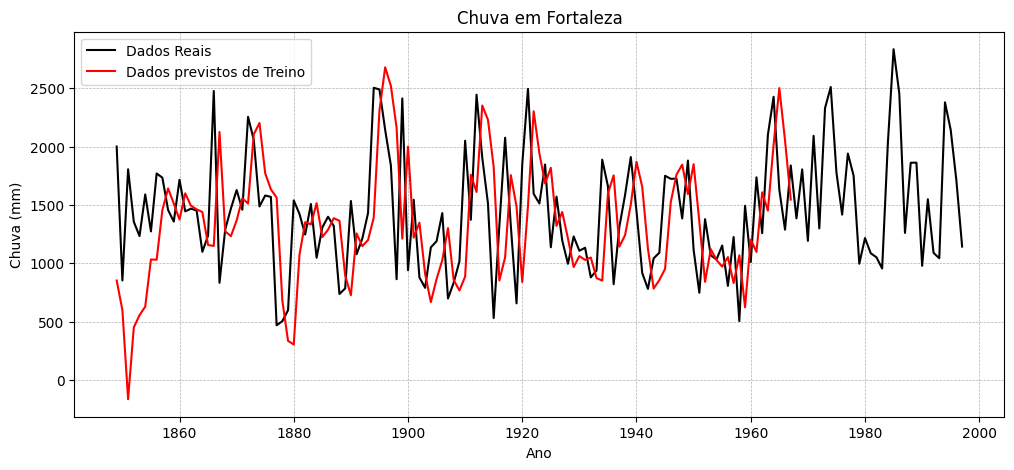

In [ ]:
mse = mean_squared_error(train_set, SEH_opt.fittedvalues)

plt.figure(figsize=(12,5))
plt.plot(train_set, color='black', label='Dados Reais')
plt.plot(SEH_opt.fittedvalues, color='red', label=f'Dados previstos de Treino - Erro: {mse.round(2)}')
plt.legend()
plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997) - optimized = True', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

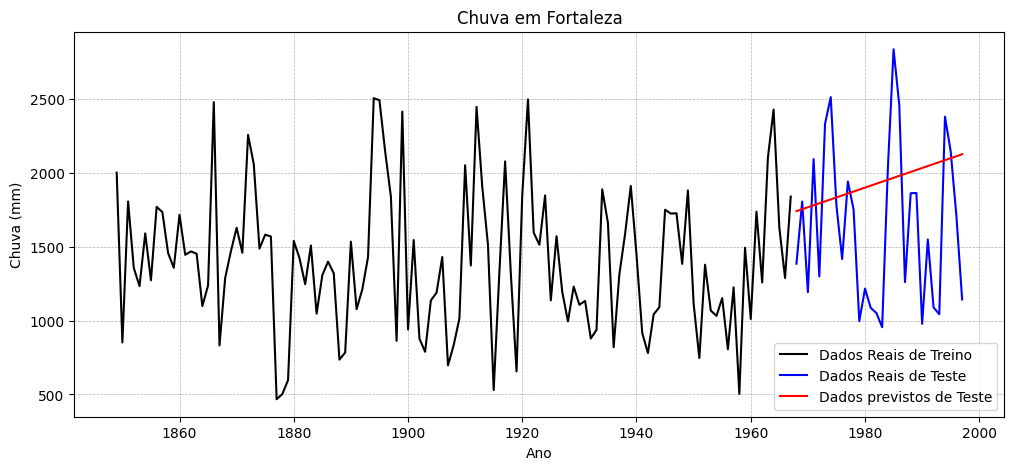

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_set, color='black', label='Dados Reais de Treino')
plt.scatter(test_set.index[0], test_set.iloc[0], color='blue', label='Valor Real')
plt.scatter(test_set.index[0], SEH_opt.forecast(1), color='red', marker='o', label='Valor Previsto')


x_values = [test_set.index[0], test_set.index[0]]
y_values = [test_set.values[0][0], SEH_opt.forecast(1).values[0]]
erro = ((SEH_opt.forecast(1).values[0] - test_set.values[0][0])*2)*(1/2)
plt.plot(x_values, y_values, linestyle='--', color='green', label=f'Erro: {erro.round(2)}')

plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997) - optimized = True', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


In [ ]:
print(f'MSE TESTE: {mean_squared_error(test_set,SEH_opt.forecast(len(test_set)))}')
print(f'RMSE TESTE: {mean_squared_error(test_set,SEH_opt.forecast(len(test_set)))**(1/2)}')

MSE TESTE: 386400.1083716358
RMSE TESTE: 621.6108978868017


In [ ]:
print(f'MSE TREINO: {mean_squared_error(train_set,SEH_opt.fittedvalues)}')
print(f'RMSE TREINO: {mean_squared_error(train_set,SEH_opt.fittedvalues)**(1/2)}')

MSE TREINO: 375478.9290843687
RMSE TREINO: 612.7633548804699


In [ ]:
forecast_index = pd.Timestamp('1998-01-01')


plt.figure(figsize=(12,5))
plt.plot(data1['Fort'], color='black', label='Dados Reais de Treino')

plt.scatter(forecast_index, SEH_opt.forecast(1), color='red', marker='o', label=f'Valor Previsto:{str(forecast_index).split()[0]}  -  {SEH_opt.forecast(1)[0].round(2)}')

plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997) - optimized = True', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

Podemos analisar pelo gráfico que o modelo é ruim pois ele captura a "movimentação" da série de forma retardada.
Além disso, apresenta péssima capacidade de predição

<h4> <b> Podemos concluir que suavização exponencial de Holt não performa bem nesta série devido a incapacidade de previsão e fitting retardado</b></h4>

<h2> Suavização Exponencial de Holt-Winter</h2>

Com Season Periods = 58, encontramos o menor erro, porém ele tende a dar overfitting na base de treino e performa muito mal na base de teste.
Por esse motivo, estamos limitando um pouco o range do périodo sazonal para evitar que casos assim aconteçam novamente

In [ ]:
threshold = int(0.8*len(data1['Fort']))
train_set = data1[:threshold]
test_set = data1[threshold:]

In [ ]:
# sesonal periods precisa começar com pelo menos 2
#como estamos fazendo treino-teste, o valor máximo de seasonal periods é 59
season = 2
menor_mse = float('inf')
melhor_sp = 0
trend = ['add','mul']
seasonal = ['add','mul']
melhor_trend = ''
melhor_seasonal = ''
for t in trend:
    print(t)
    for s in seasonal:
        print(s)
        for i in range(2,40):
            SE = ExponentialSmoothing(train_set, seasonal_periods=i, trend=t, seasonal=s).fit()
            MSE_Treino = ((SE.resid)**2).mean()
            if MSE_Treino < menor_mse:
                menor_mse = MSE_Treino
                melhor_sp = i
                melhor_trend = t
                melhor_seasonal = s

            MSE_Teste = mean_squared_error(test_set,SE.forecast(len(test_set)))
            print(f'SEASONAL PERIOD= {i} MSE TREINO: {round(MSE_Treino,2)} MSE TESTE: {round(MSE_Teste,2)}')

print(f'MENOR MSE TREINO={round(menor_mse,2)} MELHOR SP = {round(melhor_sp,2)} MELHOR TREND = {melhor_trend} MELHOR SEASONAL = {melhor_seasonal}')


add
add


SEASONAL PERIOD= 2 MSE TREINO: 245036.0 MSE TESTE: 282344.44
SEASONAL PERIOD= 3 MSE TREINO: 246117.71 MSE TESTE: 275639.33
SEASONAL PERIOD= 4 MSE TREINO: 258418.72 MSE TESTE: 282069.6
SEASONAL PERIOD= 5 MSE TREINO: 247036.51 MSE TESTE: 268998.82
SEASONAL PERIOD= 6 MSE TREINO: 259571.71 MSE TESTE: 287768.68
SEASONAL PERIOD= 7 MSE TREINO: 243308.14 MSE TESTE: 318533.0
SEASONAL PERIOD= 8 MSE TREINO: 239905.36 MSE TESTE: 367503.01
SEASONAL PERIOD= 9 MSE TREINO: 230325.16 MSE TESTE: 435735.33
SEASONAL PERIOD= 10 MSE TREINO: 241740.22 MSE TESTE: 401822.07
SEASONAL PERIOD= 11 MSE TREINO: 236048.08 MSE TESTE: 427420.27
SEASONAL PERIOD= 12 MSE TREINO: 244287.49 MSE TESTE: 402007.81
SEASONAL PERIOD= 13 MSE TREINO: 188165.23 MSE TESTE: 420954.16
SEASONAL PERIOD= 14 MSE TREINO: 245538.33 MSE TESTE: 434023.9
SEASONAL PERIOD= 15 MSE TREINO: 251865.0 MSE TESTE: 300755.22
SEASONAL PERIOD= 16 MSE TREINO: 238099.11 MSE TESTE: 321097.04
SEASONAL PERIOD= 17 MSE TREINO: 216903.0 MSE TESTE: 304450.02
SEASON

In [ ]:
SE_final = ExponentialSmoothing(train_set, seasonal_periods=melhor_sp, trend=melhor_trend, seasonal=melhor_seasonal).fit()

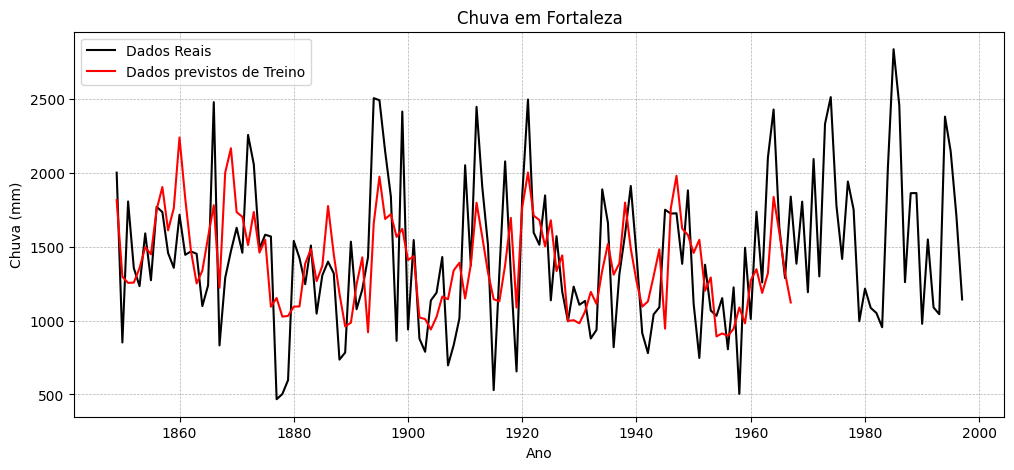

In [ ]:
mse = mean_squared_error(train_set, SE_final.fittedvalues)

plt.figure(figsize=(12,5))
plt.plot(train_set, color='black', label='Dados Reais')
plt.plot(SE_final.fittedvalues, color='red', label=f'Dados previstos de Treino - Erro:{mse.round(2)}')
plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

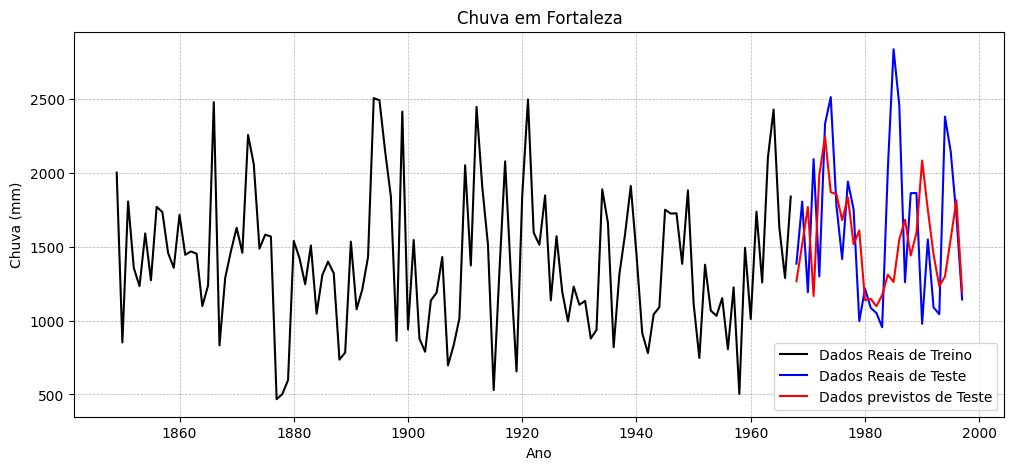

In [ ]:
mse = mean_squared_error(test_set,SE_final.forecast(len(test_set)))

plt.figure(figsize=(12,5))
#plt.plot(train_set, color='black', label='Dados Reais de Treino')
plt.plot(test_set, color='blue', label='Dados Reais de Teste')
plt.plot(SE_final.forecast(len(test_set)), color='red', label=f'Dados previstos de Teste - Erro: {mse.round(2)}')
plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
print(f'MSE TESTE: {mean_squared_error(test_set,SE_final.forecast(len(test_set)))}')
print(f'RMSE TESTE: {mean_squared_error(test_set,SE_final.forecast(len(test_set)))**(1/2)}')

MSE TESTE: 332308.2067071149
RMSE TESTE: 576.4617998680527


In [ ]:
print(f'MSE TREINO: {mean_squared_error(train_set,SE_final.fittedvalues)}')
print(f'RMSE TREINO: {mean_squared_error(train_set,SE_final.fittedvalues)**(1/2)}')

MSE TREINO: 157476.62174943218
RMSE TREINO: 396.8332417394392


In [ ]:
forecast_index = pd.Timestamp('1998-01-01')


plt.figure(figsize=(12,5))
plt.plot(data1['Fort'], color='black', label='Dados Reais de Treino')

plt.scatter(forecast_index, SE_final.forecast(1), color='red', marker='o', label=f'Valor Previsto:{str(forecast_index).split()[0]}  -  {SE_final.forecast(1)[0].round(2)}')

plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

<h4> <b> Podemos concluir que suavização exponencial de Holt-Winter performa bem nesta série devido a alta capacidade preditiva e fitting adequado</b></h4>

<h2> Árvore de decisão</h2>

In [ ]:
#vamos manter os valores de profundidade da arvore e valores de shift relativamente baixos para evitar overfitting
menor_mse = float('inf')
melhor_p = 0
melhor_depth = 0
for p in range(1,31):
    print('VALOR P ', p)
    data1_tree = data1.copy()
    for i in range(p):
        data1_tree[f'X_{i+1}'] = data1_tree['Fort'].shift(i+1)
    data1_tree.dropna(axis=0, inplace=True)
    x = data1_tree.drop('Fort', axis=1)
    y = data1_tree['Fort']
    for depth in range(1,6):
        print('VALOR DEPTH ', depth)
        model = DecisionTreeRegressor(max_depth=depth) # Com poda (prune)
        threshold = int(0.8*len(data1_tree))
        x_train = x[:threshold]
        x_test = x[threshold:]
        y_train = y[:threshold]
        y_test = y[threshold:]
        model.fit(x_train,y_train)
        MSE_Treino = mean_squared_error(y_train,model.predict(x_train))
        if MSE_Treino < menor_mse:
            menor_mse = MSE_Treino
            melhor_p = p
            melhor_depth = depth
        MSE_Teste = mean_squared_error(model.predict(x_test),y_test.values)
        print(f'P = {p} DEPTJ = {depth} MSE TREINO: {round(MSE_Treino,2)} MSE TESTE: {round(MSE_Teste,2)}')

print(f'MENOR MSE TREINO={round(menor_mse,2)} MELHOR P = {melhor_p} MELHOR PROFUNDIDADE = {melhor_depth}')

VALOR P  1
VALOR DEPTH  1
P = 1 DEPTJ = 1 MSE TREINO: 209206.3 MSE TESTE: 297886.39
VALOR DEPTH  2
P = 1 DEPTJ = 2 MSE TREINO: 193338.68 MSE TESTE: 296138.39
VALOR DEPTH  3
P = 1 DEPTJ = 3 MSE TREINO: 181725.69 MSE TESTE: 301295.9
VALOR DEPTH  4
P = 1 DEPTJ = 4 MSE TREINO: 160690.77 MSE TESTE: 338026.11
VALOR DEPTH  5
P = 1 DEPTJ = 5 MSE TREINO: 150262.71 MSE TESTE: 337749.56
VALOR P  2
VALOR DEPTH  1
P = 2 DEPTJ = 1 MSE TREINO: 208529.3 MSE TESTE: 320381.6
VALOR DEPTH  2
P = 2 DEPTJ = 2 MSE TREINO: 190763.1 MSE TESTE: 295422.98
VALOR DEPTH  3
P = 2 DEPTJ = 3 MSE TREINO: 173586.74 MSE TESTE: 315022.96
VALOR DEPTH  4
P = 2 DEPTJ = 4 MSE TREINO: 156224.73 MSE TESTE: 297456.04
VALOR DEPTH  5
P = 2 DEPTJ = 5 MSE TREINO: 130565.68 MSE TESTE: 378857.25
VALOR P  3
VALOR DEPTH  1
P = 3 DEPTJ = 1 MSE TREINO: 207511.25 MSE TESTE: 322389.17
VALOR DEPTH  2
P = 3 DEPTJ = 2 MSE TREINO: 183484.88 MSE TESTE: 309486.55
VALOR DEPTH  3
P = 3 DEPTJ = 3 MSE TREINO: 157227.26 MSE TESTE: 337082.02
VALOR DEPT

P = 5 DEPTJ = 4 MSE TREINO: 119509.12 MSE TESTE: 362540.36
VALOR DEPTH  5
P = 5 DEPTJ = 5 MSE TREINO: 94684.05 MSE TESTE: 379789.93
VALOR P  6
VALOR DEPTH  1
P = 6 DEPTJ = 1 MSE TREINO: 210420.87 MSE TESTE: 332310.79
VALOR DEPTH  2
P = 6 DEPTJ = 2 MSE TREINO: 178808.96 MSE TESTE: 365759.68
VALOR DEPTH  3
P = 6 DEPTJ = 3 MSE TREINO: 139484.88 MSE TESTE: 402089.65
VALOR DEPTH  4
P = 6 DEPTJ = 4 MSE TREINO: 99917.68 MSE TESTE: 388160.93
VALOR DEPTH  5
P = 6 DEPTJ = 5 MSE TREINO: 76498.76 MSE TESTE: 406925.69
VALOR P  7
VALOR DEPTH  1
P = 7 DEPTJ = 1 MSE TREINO: 211851.56 MSE TESTE: 331341.62
VALOR DEPTH  2
P = 7 DEPTJ = 2 MSE TREINO: 180236.36 MSE TESTE: 364788.62
VALOR DEPTH  3
P = 7 DEPTJ = 3 MSE TREINO: 140648.28 MSE TESTE: 401356.62
VALOR DEPTH  4
P = 7 DEPTJ = 4 MSE TREINO: 99527.36 MSE TESTE: 386166.29
VALOR DEPTH  5
P = 7 DEPTJ = 5 MSE TREINO: 77124.94 MSE TESTE: 407221.88
VALOR P  8
VALOR DEPTH  1
P = 8 DEPTJ = 1 MSE TREINO: 211171.95 MSE TESTE: 394252.34
VALOR DEPTH  2
P = 8 DEPT

In [ ]:
data1_tree = data1.copy()
p = melhor_p
for i in range(p):
  data1_tree[f'X_{i+1}'] = data1_tree['Fort'].shift(i+1)
data1_tree.dropna(axis=0, inplace=True)
x = data1_tree.drop('Fort', axis=1)
y = data1_tree['Fort']
threshold = int(0.8*len(data1_tree))
x_train = x[:threshold]
x_test = x[threshold:]
y_train = y[:threshold]
y_test = y[threshold:]

In [ ]:
tree_final = DecisionTreeRegressor(max_depth=melhor_depth)
tree_final.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=5)

In [ ]:
fitted = tree_final.predict(x_train)
fitted

array([1383.93103448, 1383.93103448,  904.18181818,  904.18181818,
        904.18181818, 1616.125     , 1616.125     ,  904.18181818,
       1232.42857143, 1047.        , 1321.66666667, 1383.93103448,
       1383.93103448,  904.18181818,  904.18181818, 1383.93103448,
        904.18181818, 1321.66666667, 1383.93103448, 2505.        ,
       2491.        , 1383.93103448, 1383.93103448,  863.        ,
       1806.4       , 1806.4       , 1643.4       ,  904.18181818,
        904.18181818, 1232.42857143, 1232.42857143, 1383.93103448,
        904.18181818, 1383.93103448,  904.18181818, 1806.4       ,
       1383.93103448, 2446.        , 1908.        , 1643.4       ,
        618.        , 1383.93103448, 2077.        , 1616.125     ,
        656.        , 1616.125     , 2294.5       , 1643.4       ,
       1806.4       , 1806.4       , 1232.42857143, 1383.93103448,
       1383.93103448,  904.18181818,  904.18181818,  904.18181818,
       1232.42857143,  904.18181818, 1383.93103448, 1616.125  

In [ ]:
dates = pd.date_range(start=y_train.index[0], periods=len(fitted), freq='AS')
fitted_dates = pd.Series(fitted, index=dates, name='Valores')
fitted_dates

1875-01-01    1383.931034
1876-01-01    1383.931034
1877-01-01     904.181818
1878-01-01     904.181818
1879-01-01     904.181818
                 ...     
1968-01-01    1383.931034
1969-01-01    1616.125000
1970-01-01    1383.931034
1971-01-01    2294.500000
1972-01-01    1232.428571
Freq: AS-JAN, Name: Valores, Length: 98, dtype: float64

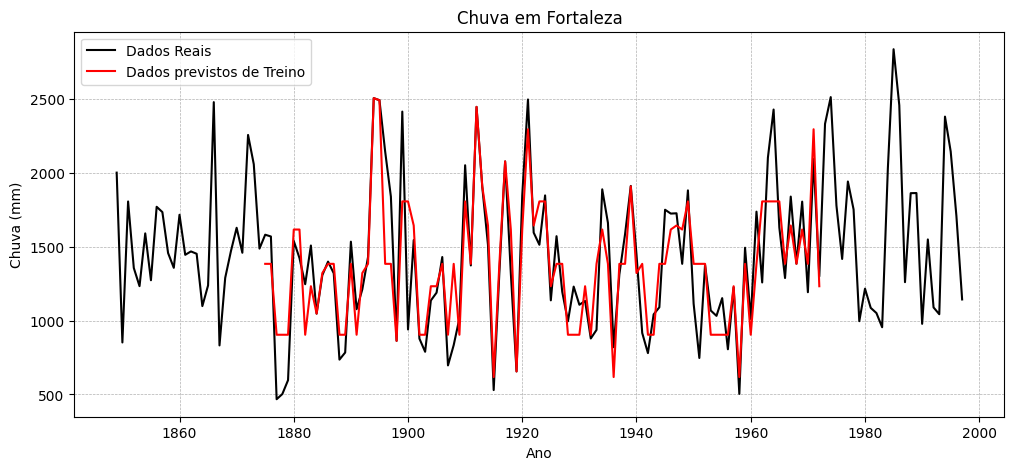

In [ ]:
mse = mean_squared_error(fitted,data1[data1.index.isin(fitted_dates.index.tolist())]['Fort'].tolist())

plt.figure(figsize=(12,5))
plt.plot(train_set, color='black', label='Dados Reais')
plt.plot(fitted_dates, color='red', label=f'Dados previstos de Treino - Erro: {mse.round(2)}')
plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
forecast= tree_final.predict(x_test)
forecast

array([2294.5       , 1806.4       , 2505.        , 1643.4       ,
        863.        , 1383.93103448, 1643.4       , 1383.93103448,
        904.18181818,  904.18181818,  904.18181818,  904.18181818,
        656.        , 1643.4       , 1383.93103448, 1383.93103448,
       1383.93103448, 1321.66666667, 1383.93103448,  904.18181818,
        656.        ,  904.18181818, 1383.93103448, 1643.4       ,
       1616.125     ])

In [ ]:
dates = pd.date_range(start=y_test.index[0], periods=len(forecast), freq='AS')
forecast_dates = pd.Series(forecast, index=dates, name='Valores')
forecast_dates

1973-01-01    2294.500000
1974-01-01    1806.400000
1975-01-01    2505.000000
1976-01-01    1643.400000
1977-01-01     863.000000
1978-01-01    1383.931034
1979-01-01    1643.400000
1980-01-01    1383.931034
1981-01-01     904.181818
1982-01-01     904.181818
1983-01-01     904.181818
1984-01-01     904.181818
1985-01-01     656.000000
1986-01-01    1643.400000
1987-01-01    1383.931034
1988-01-01    1383.931034
1989-01-01    1383.931034
1990-01-01    1321.666667
1991-01-01    1383.931034
1992-01-01     904.181818
1993-01-01     656.000000
1994-01-01     904.181818
1995-01-01    1383.931034
1996-01-01    1643.400000
1997-01-01    1616.125000
Freq: AS-JAN, Name: Valores, dtype: float64

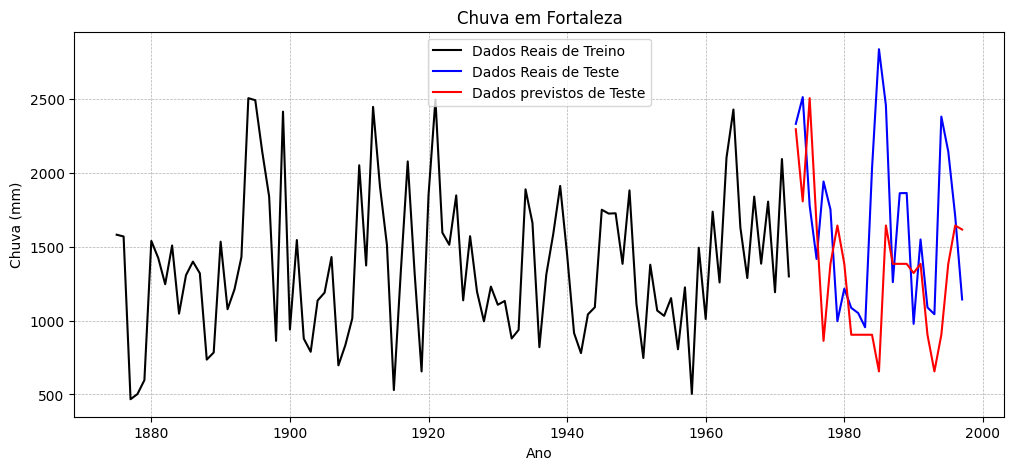

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(y_train, color='black', label='Dados Reais de Treino')
plt.plot(y_test, color='blue', label='Dados Reais de Teste')
plt.plot(forecast_dates, color='red', label='Dados previstos de Teste')
plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
print("MSE TREINO",mean_squared_error(y_train,fitted_dates))
print("RMSE TREINO",mean_squared_error(y_train,fitted_dates)**(1/2))

MSE TREINO 66357.63766070019
RMSE TREINO 257.5997625400695


In [ ]:
print("MSE TESTE",mean_squared_error(y_test,forecast_dates))
print("RMSE TESTE",mean_squared_error(y_test,forecast_dates)**(1/2))

MSE TESTE 533883.7808512731
RMSE TESTE 730.6735118035093


In [ ]:
mse = mean_squared_error(forecast_dates,data1[data1.index.isin(forecast_dates.index.tolist())]['Fort'].tolist())
plt.figure(figsize=(12,5))
plt.plot(y_test, color='blue', label='Dados Reais de Teste')
plt.plot(forecast_dates, color='red', label=f'Dados previstos de Teste - Erro: {mse.round(2)}')
plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
forecast_index = pd.Timestamp('1998-01-01')


plt.figure(figsize=(12,5))
plt.plot(data1['Fort'], color='black', label='Dados Reais de Treino')

plt.scatter(forecast_index, SE_final.forecast(1), color='red', marker='o', label=f'Valor Previsto:{str(forecast_index).split()[0]}  -  {SE_final.forecast(1)[0].round(2)}')

plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

<h2> Prophet </h2>

In [ ]:
data1_prop = pd.read_excel('https://www.ime.usp.br/~pam/fortaleza.xls')
data1_prop['Ano'] = pd.to_datetime(data1_prop['Ano'], format='%Y') + pd.offsets.YearBegin(0)
data1_prop = data1_prop.rename(columns={'Ano': 'ds'})
data1_prop = data1_prop.rename(columns={'Fort': 'y'})

In [ ]:
# treino -teste
train_size = int(len(data1_prop) * 0.8)
train = data1_prop[:train_size]
test = data1_prop[train_size:]

In [ ]:
change=1
menor_mse = float('inf')
melhor_change = 0
melhor_seasonal_scale = 0
for season_scale in range(1,21):
    change=0.1
    while True:
        if change>1:
            break
        model = Prophet(
        growth='linear',                   # Define o crescimento como linear
        changepoint_prior_scale=change,       # Ajusta a sensibilidade aos pontos de mudança na série temporal
        seasonality_prior_scale=season_scale,        # Escala do prior para a sazonalidade
        seasonality_mode='multiplicative', # Utiliza a sazonalidade multiplicativa para se adaptar a mudanças
        yearly_seasonality=True,           # Mantém a sazonalidade anual
        weekly_seasonality=False,          # Sem sazonalidade semanal (se não aplicável)
        daily_seasonality=False            # Sem sazonalidade diária (se não aplicável)
        )

        # Ajusta o modelo aos dados (substitua 'data2' pelo seu DataFrame)
        model.fit(train)
        fitted = model.predict(train)
        MSE_Treino = mean_squared_error(train['y'], fitted['yhat'])
        if MSE_Treino < menor_mse:
            menor_mse = MSE_Treino
            melhor_change = change
            melhor_seasonal_scale = season_scale
        print(f'MSE TREINO {MSE_Treino} CHANGE = {change} SEASONAL SCALE {season_scale}')
        change+=0.1
        change = round(change,2)

print(f'MENOR MSE TREINO = {menor_mse} MELHOR CHANGE = {melhor_change} MELHOR SEASONAL SCALE = {melhor_seasonal_scale}')

23:38:40 - cmdstanpy - INFO - Chain [1] start processing
23:38:40 - cmdstanpy - INFO - Chain [1] done processing
23:38:40 - cmdstanpy - INFO - Chain [1] start processing
23:38:40 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 223583.2491892936 CHANGE = 0.1 SEASONAL SCALE 1
MSE TREINO 222114.04182700417 CHANGE = 0.2 SEASONAL SCALE 1


23:38:41 - cmdstanpy - INFO - Chain [1] start processing
23:38:41 - cmdstanpy - INFO - Chain [1] done processing
23:38:41 - cmdstanpy - INFO - Chain [1] start processing
23:38:41 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 222177.5498443528 CHANGE = 0.3 SEASONAL SCALE 1
MSE TREINO 221506.3402685705 CHANGE = 0.4 SEASONAL SCALE 1


23:38:41 - cmdstanpy - INFO - Chain [1] start processing
23:38:41 - cmdstanpy - INFO - Chain [1] done processing
23:38:41 - cmdstanpy - INFO - Chain [1] start processing
23:38:41 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221322.76824485042 CHANGE = 0.5 SEASONAL SCALE 1
MSE TREINO 221125.05261121987 CHANGE = 0.6 SEASONAL SCALE 1


23:38:41 - cmdstanpy - INFO - Chain [1] start processing
23:38:41 - cmdstanpy - INFO - Chain [1] done processing
23:38:41 - cmdstanpy - INFO - Chain [1] start processing
23:38:41 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221120.30127872928 CHANGE = 0.7 SEASONAL SCALE 1
MSE TREINO 220976.78060856133 CHANGE = 0.8 SEASONAL SCALE 1


23:38:41 - cmdstanpy - INFO - Chain [1] start processing
23:38:41 - cmdstanpy - INFO - Chain [1] done processing
23:38:42 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 220716.25073695675 CHANGE = 0.9 SEASONAL SCALE 1


23:38:42 - cmdstanpy - INFO - Chain [1] done processing
23:38:42 - cmdstanpy - INFO - Chain [1] start processing
23:38:42 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 181343.20031524947 CHANGE = 1.0 SEASONAL SCALE 1
MSE TREINO 223631.34701419369 CHANGE = 0.1 SEASONAL SCALE 2


23:38:42 - cmdstanpy - INFO - Chain [1] start processing
23:38:42 - cmdstanpy - INFO - Chain [1] done processing
23:38:42 - cmdstanpy - INFO - Chain [1] start processing
23:38:42 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 222749.8116655402 CHANGE = 0.2 SEASONAL SCALE 2
MSE TREINO 221986.2764814561 CHANGE = 0.3 SEASONAL SCALE 2


23:38:42 - cmdstanpy - INFO - Chain [1] start processing
23:38:42 - cmdstanpy - INFO - Chain [1] done processing
23:38:43 - cmdstanpy - INFO - Chain [1] start processing
23:38:43 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221583.9897088588 CHANGE = 0.4 SEASONAL SCALE 2
MSE TREINO 221335.93023603372 CHANGE = 0.5 SEASONAL SCALE 2


23:38:43 - cmdstanpy - INFO - Chain [1] start processing
23:38:43 - cmdstanpy - INFO - Chain [1] done processing
23:38:43 - cmdstanpy - INFO - Chain [1] start processing
23:38:43 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221100.2528910632 CHANGE = 0.6 SEASONAL SCALE 2
MSE TREINO 221059.87868502832 CHANGE = 0.7 SEASONAL SCALE 2


23:38:43 - cmdstanpy - INFO - Chain [1] start processing
23:38:43 - cmdstanpy - INFO - Chain [1] done processing
23:38:43 - cmdstanpy - INFO - Chain [1] start processing
23:38:43 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 220948.8224989201 CHANGE = 0.8 SEASONAL SCALE 2


23:38:43 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 166999.0353743261 CHANGE = 0.9 SEASONAL SCALE 2


23:38:43 - cmdstanpy - INFO - Chain [1] done processing
23:38:44 - cmdstanpy - INFO - Chain [1] start processing
23:38:44 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 163808.8512709881 CHANGE = 1.0 SEASONAL SCALE 2
MSE TREINO 223577.6405975926 CHANGE = 0.1 SEASONAL SCALE 3


23:38:44 - cmdstanpy - INFO - Chain [1] start processing
23:38:44 - cmdstanpy - INFO - Chain [1] done processing
23:38:44 - cmdstanpy - INFO - Chain [1] start processing
23:38:44 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 222591.0278280462 CHANGE = 0.2 SEASONAL SCALE 3
MSE TREINO 221972.7202541211 CHANGE = 0.3 SEASONAL SCALE 3


23:38:44 - cmdstanpy - INFO - Chain [1] start processing
23:38:44 - cmdstanpy - INFO - Chain [1] done processing
23:38:44 - cmdstanpy - INFO - Chain [1] start processing
23:38:44 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221615.15383470219 CHANGE = 0.4 SEASONAL SCALE 3
MSE TREINO 221376.46871974738 CHANGE = 0.5 SEASONAL SCALE 3


23:38:44 - cmdstanpy - INFO - Chain [1] start processing
23:38:44 - cmdstanpy - INFO - Chain [1] done processing
23:38:45 - cmdstanpy - INFO - Chain [1] start processing
23:38:45 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221018.84518608407 CHANGE = 0.6 SEASONAL SCALE 3
MSE TREINO 220993.19957001272 CHANGE = 0.7 SEASONAL SCALE 3


23:38:45 - cmdstanpy - INFO - Chain [1] start processing
23:38:45 - cmdstanpy - INFO - Chain [1] done processing
23:38:45 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 221074.8211797986 CHANGE = 0.8 SEASONAL SCALE 3


23:38:45 - cmdstanpy - INFO - Chain [1] done processing
23:38:45 - cmdstanpy - INFO - Chain [1] start processing
23:38:45 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 162524.4750755412 CHANGE = 0.9 SEASONAL SCALE 3
MSE TREINO 161381.842253955 CHANGE = 1.0 SEASONAL SCALE 3


23:38:45 - cmdstanpy - INFO - Chain [1] start processing
23:38:45 - cmdstanpy - INFO - Chain [1] done processing
23:38:46 - cmdstanpy - INFO - Chain [1] start processing
23:38:46 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 223574.1902335121 CHANGE = 0.1 SEASONAL SCALE 4
MSE TREINO 222754.23204559556 CHANGE = 0.2 SEASONAL SCALE 4


23:38:46 - cmdstanpy - INFO - Chain [1] start processing
23:38:46 - cmdstanpy - INFO - Chain [1] done processing
23:38:46 - cmdstanpy - INFO - Chain [1] start processing
23:38:46 - cmdstanpy - INFO - Chain [1] done processing
23:38:46 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 221971.99953936273 CHANGE = 0.3 SEASONAL SCALE 4
MSE TREINO 221595.7148470314 CHANGE = 0.4 SEASONAL SCALE 4


23:38:46 - cmdstanpy - INFO - Chain [1] done processing
23:38:46 - cmdstanpy - INFO - Chain [1] start processing
23:38:46 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221321.30396602603 CHANGE = 0.5 SEASONAL SCALE 4
MSE TREINO 221041.86937790224 CHANGE = 0.6 SEASONAL SCALE 4


23:38:46 - cmdstanpy - INFO - Chain [1] start processing
23:38:46 - cmdstanpy - INFO - Chain [1] done processing
23:38:46 - cmdstanpy - INFO - Chain [1] start processing
23:38:46 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 220978.97102916875 CHANGE = 0.7 SEASONAL SCALE 4
MSE TREINO 221011.8672010294 CHANGE = 0.8 SEASONAL SCALE 4


23:38:47 - cmdstanpy - INFO - Chain [1] start processing
23:38:47 - cmdstanpy - INFO - Chain [1] done processing
23:38:47 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 159485.65860134512 CHANGE = 0.9 SEASONAL SCALE 4


23:38:47 - cmdstanpy - INFO - Chain [1] done processing
23:38:47 - cmdstanpy - INFO - Chain [1] start processing
23:38:47 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 158378.8548060473 CHANGE = 1.0 SEASONAL SCALE 4
MSE TREINO 223581.5449694082 CHANGE = 0.1 SEASONAL SCALE 5


23:38:47 - cmdstanpy - INFO - Chain [1] start processing
23:38:47 - cmdstanpy - INFO - Chain [1] done processing
23:38:47 - cmdstanpy - INFO - Chain [1] start processing
23:38:47 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 222804.15592063213 CHANGE = 0.2 SEASONAL SCALE 5
MSE TREINO 221994.45318294506 CHANGE = 0.3 SEASONAL SCALE 5


23:38:48 - cmdstanpy - INFO - Chain [1] start processing
23:38:48 - cmdstanpy - INFO - Chain [1] done processing
23:38:48 - cmdstanpy - INFO - Chain [1] start processing
23:38:48 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221583.43515177205 CHANGE = 0.4 SEASONAL SCALE 5
MSE TREINO 221305.88372141033 CHANGE = 0.5 SEASONAL SCALE 5


23:38:48 - cmdstanpy - INFO - Chain [1] start processing
23:38:48 - cmdstanpy - INFO - Chain [1] done processing
23:38:48 - cmdstanpy - INFO - Chain [1] start processing
23:38:48 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221135.6728865836 CHANGE = 0.6 SEASONAL SCALE 5
MSE TREINO 221040.9457837053 CHANGE = 0.7 SEASONAL SCALE 5


23:38:48 - cmdstanpy - INFO - Chain [1] start processing
23:38:48 - cmdstanpy - INFO - Chain [1] done processing
23:38:48 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 221017.45315115014 CHANGE = 0.8 SEASONAL SCALE 5


23:38:48 - cmdstanpy - INFO - Chain [1] done processing
23:38:49 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 159094.8072524712 CHANGE = 0.9 SEASONAL SCALE 5


23:38:49 - cmdstanpy - INFO - Chain [1] done processing
23:38:49 - cmdstanpy - INFO - Chain [1] start processing
23:38:49 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 157694.61021455846 CHANGE = 1.0 SEASONAL SCALE 5
MSE TREINO 223603.4889834188 CHANGE = 0.1 SEASONAL SCALE 6


23:38:49 - cmdstanpy - INFO - Chain [1] start processing
23:38:49 - cmdstanpy - INFO - Chain [1] done processing
23:38:49 - cmdstanpy - INFO - Chain [1] start processing
23:38:49 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 222529.34009370377 CHANGE = 0.2 SEASONAL SCALE 6
MSE TREINO 221921.93873269114 CHANGE = 0.3 SEASONAL SCALE 6


23:38:49 - cmdstanpy - INFO - Chain [1] start processing
23:38:49 - cmdstanpy - INFO - Chain [1] done processing
23:38:50 - cmdstanpy - INFO - Chain [1] start processing
23:38:50 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221540.0869718115 CHANGE = 0.4 SEASONAL SCALE 6
MSE TREINO 221335.75783462412 CHANGE = 0.5 SEASONAL SCALE 6


23:38:50 - cmdstanpy - INFO - Chain [1] start processing
23:38:50 - cmdstanpy - INFO - Chain [1] done processing
23:38:50 - cmdstanpy - INFO - Chain [1] start processing
23:38:50 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221079.04432307972 CHANGE = 0.6 SEASONAL SCALE 6
MSE TREINO 221011.10960596893 CHANGE = 0.7 SEASONAL SCALE 6


23:38:50 - cmdstanpy - INFO - Chain [1] start processing
23:38:50 - cmdstanpy - INFO - Chain [1] done processing
23:38:50 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 220997.58980011664 CHANGE = 0.8 SEASONAL SCALE 6


23:38:50 - cmdstanpy - INFO - Chain [1] done processing
23:38:51 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 157670.80293788976 CHANGE = 0.9 SEASONAL SCALE 6


23:38:51 - cmdstanpy - INFO - Chain [1] done processing
23:38:51 - cmdstanpy - INFO - Chain [1] start processing
23:38:51 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 156755.25866272557 CHANGE = 1.0 SEASONAL SCALE 6
MSE TREINO 223616.0269213947 CHANGE = 0.1 SEASONAL SCALE 7


23:38:51 - cmdstanpy - INFO - Chain [1] start processing
23:38:51 - cmdstanpy - INFO - Chain [1] done processing
23:38:51 - cmdstanpy - INFO - Chain [1] start processing
23:38:51 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 222819.87557857065 CHANGE = 0.2 SEASONAL SCALE 7
MSE TREINO 221975.72212894994 CHANGE = 0.3 SEASONAL SCALE 7


23:38:51 - cmdstanpy - INFO - Chain [1] start processing
23:38:51 - cmdstanpy - INFO - Chain [1] done processing
23:38:51 - cmdstanpy - INFO - Chain [1] start processing
23:38:51 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221514.9112299458 CHANGE = 0.4 SEASONAL SCALE 7
MSE TREINO 221296.17052995687 CHANGE = 0.5 SEASONAL SCALE 7


23:38:52 - cmdstanpy - INFO - Chain [1] start processing
23:38:52 - cmdstanpy - INFO - Chain [1] done processing
23:38:52 - cmdstanpy - INFO - Chain [1] start processing
23:38:52 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221092.32445739929 CHANGE = 0.6 SEASONAL SCALE 7
MSE TREINO 221080.18393670488 CHANGE = 0.7 SEASONAL SCALE 7


23:38:52 - cmdstanpy - INFO - Chain [1] start processing
23:38:52 - cmdstanpy - INFO - Chain [1] done processing
23:38:52 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 220990.68115154476 CHANGE = 0.8 SEASONAL SCALE 7


23:38:52 - cmdstanpy - INFO - Chain [1] done processing
23:38:52 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 157901.615679718 CHANGE = 0.9 SEASONAL SCALE 7


23:38:52 - cmdstanpy - INFO - Chain [1] done processing
23:38:53 - cmdstanpy - INFO - Chain [1] start processing
23:38:53 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 157429.71866190818 CHANGE = 1.0 SEASONAL SCALE 7
MSE TREINO 223620.91564833643 CHANGE = 0.1 SEASONAL SCALE 8


23:38:53 - cmdstanpy - INFO - Chain [1] start processing
23:38:53 - cmdstanpy - INFO - Chain [1] done processing
23:38:53 - cmdstanpy - INFO - Chain [1] start processing
23:38:53 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 222586.9266545453 CHANGE = 0.2 SEASONAL SCALE 8
MSE TREINO 222003.17223689595 CHANGE = 0.3 SEASONAL SCALE 8


23:38:53 - cmdstanpy - INFO - Chain [1] start processing
23:38:53 - cmdstanpy - INFO - Chain [1] done processing
23:38:53 - cmdstanpy - INFO - Chain [1] start processing
23:38:53 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221577.70110591035 CHANGE = 0.4 SEASONAL SCALE 8
MSE TREINO 221319.95795970384 CHANGE = 0.5 SEASONAL SCALE 8


23:38:53 - cmdstanpy - INFO - Chain [1] start processing
23:38:53 - cmdstanpy - INFO - Chain [1] done processing
23:38:54 - cmdstanpy - INFO - Chain [1] start processing
23:38:54 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221054.20322301157 CHANGE = 0.6 SEASONAL SCALE 8
MSE TREINO 220988.58187629853 CHANGE = 0.7 SEASONAL SCALE 8


23:38:54 - cmdstanpy - INFO - Chain [1] start processing
23:38:54 - cmdstanpy - INFO - Chain [1] done processing
23:38:54 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 220938.0019558898 CHANGE = 0.8 SEASONAL SCALE 8


23:38:54 - cmdstanpy - INFO - Chain [1] done processing
23:38:54 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 157199.56271906823 CHANGE = 0.9 SEASONAL SCALE 8


23:38:55 - cmdstanpy - INFO - Chain [1] done processing
23:38:55 - cmdstanpy - INFO - Chain [1] start processing
23:38:55 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 156007.1559021447 CHANGE = 1.0 SEASONAL SCALE 8
MSE TREINO 223641.6427628673 CHANGE = 0.1 SEASONAL SCALE 9


23:38:55 - cmdstanpy - INFO - Chain [1] start processing
23:38:55 - cmdstanpy - INFO - Chain [1] done processing
23:38:55 - cmdstanpy - INFO - Chain [1] start processing
23:38:55 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 222223.4298613321 CHANGE = 0.2 SEASONAL SCALE 9
MSE TREINO 221973.3641331992 CHANGE = 0.3 SEASONAL SCALE 9


23:38:55 - cmdstanpy - INFO - Chain [1] start processing
23:38:55 - cmdstanpy - INFO - Chain [1] done processing
23:38:55 - cmdstanpy - INFO - Chain [1] start processing
23:38:55 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221477.31927523713 CHANGE = 0.4 SEASONAL SCALE 9
MSE TREINO 221317.71470706066 CHANGE = 0.5 SEASONAL SCALE 9


23:38:55 - cmdstanpy - INFO - Chain [1] start processing
23:38:55 - cmdstanpy - INFO - Chain [1] done processing
23:38:56 - cmdstanpy - INFO - Chain [1] start processing
23:38:56 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221055.13968332057 CHANGE = 0.6 SEASONAL SCALE 9
MSE TREINO 221015.91799311183 CHANGE = 0.7 SEASONAL SCALE 9


23:38:56 - cmdstanpy - INFO - Chain [1] start processing
23:38:56 - cmdstanpy - INFO - Chain [1] done processing
23:38:56 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 221028.7917699318 CHANGE = 0.8 SEASONAL SCALE 9


23:38:56 - cmdstanpy - INFO - Chain [1] done processing
23:38:56 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 157532.97579471383 CHANGE = 0.9 SEASONAL SCALE 9


23:38:56 - cmdstanpy - INFO - Chain [1] done processing
23:38:56 - cmdstanpy - INFO - Chain [1] start processing
23:38:57 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 157604.7088981358 CHANGE = 1.0 SEASONAL SCALE 9
MSE TREINO 223626.8456009182 CHANGE = 0.1 SEASONAL SCALE 10


23:38:57 - cmdstanpy - INFO - Chain [1] start processing
23:38:57 - cmdstanpy - INFO - Chain [1] done processing
23:38:57 - cmdstanpy - INFO - Chain [1] start processing
23:38:57 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 222249.99487201564 CHANGE = 0.2 SEASONAL SCALE 10
MSE TREINO 221982.5749055056 CHANGE = 0.3 SEASONAL SCALE 10


23:38:57 - cmdstanpy - INFO - Chain [1] start processing
23:38:57 - cmdstanpy - INFO - Chain [1] done processing
23:38:57 - cmdstanpy - INFO - Chain [1] start processing
23:38:57 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221520.61343462774 CHANGE = 0.4 SEASONAL SCALE 10
MSE TREINO 221319.68321476545 CHANGE = 0.5 SEASONAL SCALE 10


23:38:57 - cmdstanpy - INFO - Chain [1] start processing
23:38:57 - cmdstanpy - INFO - Chain [1] done processing
23:38:57 - cmdstanpy - INFO - Chain [1] start processing
23:38:57 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221089.4161074439 CHANGE = 0.6 SEASONAL SCALE 10
MSE TREINO 220976.82516029614 CHANGE = 0.7 SEASONAL SCALE 10


23:38:57 - cmdstanpy - INFO - Chain [1] start processing
23:38:57 - cmdstanpy - INFO - Chain [1] done processing
23:38:58 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 221000.44423520422 CHANGE = 0.8 SEASONAL SCALE 10


23:38:58 - cmdstanpy - INFO - Chain [1] done processing
23:38:58 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 156550.9734891047 CHANGE = 0.9 SEASONAL SCALE 10


23:38:58 - cmdstanpy - INFO - Chain [1] done processing
23:38:58 - cmdstanpy - INFO - Chain [1] start processing
23:38:58 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 156670.6374517929 CHANGE = 1.0 SEASONAL SCALE 10
MSE TREINO 223647.1012964839 CHANGE = 0.1 SEASONAL SCALE 11


23:38:58 - cmdstanpy - INFO - Chain [1] start processing
23:38:58 - cmdstanpy - INFO - Chain [1] done processing
23:38:59 - cmdstanpy - INFO - Chain [1] start processing
23:38:59 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 222830.25362727762 CHANGE = 0.2 SEASONAL SCALE 11


23:38:59 - cmdstanpy - INFO - Chain [1] start processing
23:38:59 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221955.83060002918 CHANGE = 0.3 SEASONAL SCALE 11
MSE TREINO 221528.0324549299 CHANGE = 0.4 SEASONAL SCALE 11


23:38:59 - cmdstanpy - INFO - Chain [1] start processing
23:38:59 - cmdstanpy - INFO - Chain [1] done processing
23:38:59 - cmdstanpy - INFO - Chain [1] start processing
23:38:59 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221350.9145694862 CHANGE = 0.5 SEASONAL SCALE 11
MSE TREINO 221087.68146523117 CHANGE = 0.6 SEASONAL SCALE 11


23:38:59 - cmdstanpy - INFO - Chain [1] start processing
23:38:59 - cmdstanpy - INFO - Chain [1] done processing
23:38:59 - cmdstanpy - INFO - Chain [1] start processing
23:38:59 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221000.20019239234 CHANGE = 0.7 SEASONAL SCALE 11
MSE TREINO 220981.749531922 CHANGE = 0.8 SEASONAL SCALE 11


23:38:59 - cmdstanpy - INFO - Chain [1] start processing
23:39:00 - cmdstanpy - INFO - Chain [1] done processing
23:39:00 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 157363.87147481804 CHANGE = 0.9 SEASONAL SCALE 11


23:39:00 - cmdstanpy - INFO - Chain [1] done processing
23:39:00 - cmdstanpy - INFO - Chain [1] start processing
23:39:00 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 157449.9988989697 CHANGE = 1.0 SEASONAL SCALE 11
MSE TREINO 223643.71077905974 CHANGE = 0.1 SEASONAL SCALE 12


23:39:00 - cmdstanpy - INFO - Chain [1] start processing
23:39:00 - cmdstanpy - INFO - Chain [1] done processing
23:39:00 - cmdstanpy - INFO - Chain [1] start processing
23:39:00 - cmdstanpy - INFO - Chain [1] done processing
23:39:00 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 222131.37274387298 CHANGE = 0.2 SEASONAL SCALE 12
MSE TREINO 221990.86984520292 CHANGE = 0.3 SEASONAL SCALE 12


23:39:00 - cmdstanpy - INFO - Chain [1] done processing
23:39:01 - cmdstanpy - INFO - Chain [1] start processing
23:39:01 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221540.2125199306 CHANGE = 0.4 SEASONAL SCALE 12
MSE TREINO 221357.6724668505 CHANGE = 0.5 SEASONAL SCALE 12


23:39:01 - cmdstanpy - INFO - Chain [1] start processing
23:39:01 - cmdstanpy - INFO - Chain [1] done processing
23:39:01 - cmdstanpy - INFO - Chain [1] start processing
23:39:01 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221066.70521102546 CHANGE = 0.6 SEASONAL SCALE 12
MSE TREINO 221089.98298143578 CHANGE = 0.7 SEASONAL SCALE 12


23:39:01 - cmdstanpy - INFO - Chain [1] start processing
23:39:01 - cmdstanpy - INFO - Chain [1] done processing
23:39:01 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 220981.12331583953 CHANGE = 0.8 SEASONAL SCALE 12


23:39:02 - cmdstanpy - INFO - Chain [1] done processing
23:39:02 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 157066.64571157013 CHANGE = 0.9 SEASONAL SCALE 12


23:39:02 - cmdstanpy - INFO - Chain [1] done processing
23:39:02 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 156740.48482485555 CHANGE = 1.0 SEASONAL SCALE 12


23:39:02 - cmdstanpy - INFO - Chain [1] done processing
23:39:02 - cmdstanpy - INFO - Chain [1] start processing
23:39:02 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 223577.8941592643 CHANGE = 0.1 SEASONAL SCALE 13
MSE TREINO 222826.3932893366 CHANGE = 0.2 SEASONAL SCALE 13


23:39:02 - cmdstanpy - INFO - Chain [1] start processing
23:39:02 - cmdstanpy - INFO - Chain [1] done processing
23:39:03 - cmdstanpy - INFO - Chain [1] start processing
23:39:03 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221931.6997180959 CHANGE = 0.3 SEASONAL SCALE 13
MSE TREINO 221554.78405245324 CHANGE = 0.4 SEASONAL SCALE 13


23:39:03 - cmdstanpy - INFO - Chain [1] start processing
23:39:03 - cmdstanpy - INFO - Chain [1] done processing
23:39:03 - cmdstanpy - INFO - Chain [1] start processing
23:39:03 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221347.86455513176 CHANGE = 0.5 SEASONAL SCALE 13
MSE TREINO 221085.36854148668 CHANGE = 0.6 SEASONAL SCALE 13


23:39:03 - cmdstanpy - INFO - Chain [1] start processing
23:39:03 - cmdstanpy - INFO - Chain [1] done processing
23:39:03 - cmdstanpy - INFO - Chain [1] start processing
23:39:03 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221022.54683397157 CHANGE = 0.7 SEASONAL SCALE 13
MSE TREINO 220990.06582131668 CHANGE = 0.8 SEASONAL SCALE 13


23:39:03 - cmdstanpy - INFO - Chain [1] start processing
23:39:03 - cmdstanpy - INFO - Chain [1] done processing
23:39:04 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 157247.5272052985 CHANGE = 0.9 SEASONAL SCALE 13


23:39:04 - cmdstanpy - INFO - Chain [1] done processing
23:39:04 - cmdstanpy - INFO - Chain [1] start processing
23:39:04 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 156762.0162260069 CHANGE = 1.0 SEASONAL SCALE 13


23:39:04 - cmdstanpy - INFO - Chain [1] start processing
23:39:04 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 223573.3843563063 CHANGE = 0.1 SEASONAL SCALE 14
MSE TREINO 222545.1695313976 CHANGE = 0.2 SEASONAL SCALE 14


23:39:04 - cmdstanpy - INFO - Chain [1] start processing
23:39:04 - cmdstanpy - INFO - Chain [1] done processing
23:39:04 - cmdstanpy - INFO - Chain [1] start processing
23:39:04 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221949.92287584298 CHANGE = 0.3 SEASONAL SCALE 14
MSE TREINO 221489.5020211678 CHANGE = 0.4 SEASONAL SCALE 14


23:39:05 - cmdstanpy - INFO - Chain [1] start processing
23:39:05 - cmdstanpy - INFO - Chain [1] done processing
23:39:05 - cmdstanpy - INFO - Chain [1] start processing
23:39:05 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221358.14372263962 CHANGE = 0.5 SEASONAL SCALE 14
MSE TREINO 221081.22439177358 CHANGE = 0.6 SEASONAL SCALE 14


23:39:05 - cmdstanpy - INFO - Chain [1] start processing
23:39:05 - cmdstanpy - INFO - Chain [1] done processing
23:39:05 - cmdstanpy - INFO - Chain [1] start processing
23:39:05 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221040.42971807224 CHANGE = 0.7 SEASONAL SCALE 14
MSE TREINO 220970.33538603384 CHANGE = 0.8 SEASONAL SCALE 14


23:39:05 - cmdstanpy - INFO - Chain [1] start processing
23:39:06 - cmdstanpy - INFO - Chain [1] done processing
23:39:06 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 157780.58970298455 CHANGE = 0.9 SEASONAL SCALE 14


23:39:06 - cmdstanpy - INFO - Chain [1] done processing
23:39:06 - cmdstanpy - INFO - Chain [1] start processing
23:39:06 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 156575.35845836622 CHANGE = 1.0 SEASONAL SCALE 14
MSE TREINO 223575.3463506326 CHANGE = 0.1 SEASONAL SCALE 15


23:39:06 - cmdstanpy - INFO - Chain [1] start processing
23:39:06 - cmdstanpy - INFO - Chain [1] done processing
23:39:06 - cmdstanpy - INFO - Chain [1] start processing
23:39:06 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 222188.475310385 CHANGE = 0.2 SEASONAL SCALE 15
MSE TREINO 221931.5040068392 CHANGE = 0.3 SEASONAL SCALE 15


23:39:06 - cmdstanpy - INFO - Chain [1] start processing
23:39:06 - cmdstanpy - INFO - Chain [1] done processing
23:39:07 - cmdstanpy - INFO - Chain [1] start processing
23:39:07 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221529.065874495 CHANGE = 0.4 SEASONAL SCALE 15
MSE TREINO 221346.73168270235 CHANGE = 0.5 SEASONAL SCALE 15


23:39:07 - cmdstanpy - INFO - Chain [1] start processing
23:39:07 - cmdstanpy - INFO - Chain [1] done processing
23:39:07 - cmdstanpy - INFO - Chain [1] start processing
23:39:07 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221093.79612607163 CHANGE = 0.6 SEASONAL SCALE 15
MSE TREINO 221092.86402998623 CHANGE = 0.7 SEASONAL SCALE 15


23:39:07 - cmdstanpy - INFO - Chain [1] start processing
23:39:07 - cmdstanpy - INFO - Chain [1] done processing
23:39:07 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 221003.77515764735 CHANGE = 0.8 SEASONAL SCALE 15


23:39:07 - cmdstanpy - INFO - Chain [1] done processing
23:39:07 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 156414.12387749963 CHANGE = 0.9 SEASONAL SCALE 15


23:39:08 - cmdstanpy - INFO - Chain [1] done processing
23:39:08 - cmdstanpy - INFO - Chain [1] start processing
23:39:08 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 156728.10028819786 CHANGE = 1.0 SEASONAL SCALE 15
MSE TREINO 223575.26940034932 CHANGE = 0.1 SEASONAL SCALE 16


23:39:08 - cmdstanpy - INFO - Chain [1] start processing
23:39:08 - cmdstanpy - INFO - Chain [1] done processing
23:39:08 - cmdstanpy - INFO - Chain [1] start processing
23:39:08 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 222178.98135080066 CHANGE = 0.2 SEASONAL SCALE 16


23:39:08 - cmdstanpy - INFO - Chain [1] start processing
23:39:08 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 222011.86999525168 CHANGE = 0.3 SEASONAL SCALE 16
MSE TREINO 221511.3844512591 CHANGE = 0.4 SEASONAL SCALE 16


23:39:08 - cmdstanpy - INFO - Chain [1] start processing
23:39:08 - cmdstanpy - INFO - Chain [1] done processing
23:39:09 - cmdstanpy - INFO - Chain [1] start processing
23:39:09 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221358.8293643745 CHANGE = 0.5 SEASONAL SCALE 16
MSE TREINO 221066.1743848039 CHANGE = 0.6 SEASONAL SCALE 16


23:39:09 - cmdstanpy - INFO - Chain [1] start processing
23:39:09 - cmdstanpy - INFO - Chain [1] done processing
23:39:09 - cmdstanpy - INFO - Chain [1] start processing
23:39:09 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221002.82412849786 CHANGE = 0.7 SEASONAL SCALE 16


23:39:09 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 220982.46287123067 CHANGE = 0.8 SEASONAL SCALE 16


23:39:09 - cmdstanpy - INFO - Chain [1] done processing
23:39:09 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 157693.51021524693 CHANGE = 0.9 SEASONAL SCALE 16


23:39:10 - cmdstanpy - INFO - Chain [1] done processing
23:39:10 - cmdstanpy - INFO - Chain [1] start processing
23:39:10 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 156840.14381323566 CHANGE = 1.0 SEASONAL SCALE 16
MSE TREINO 223570.71358494446 CHANGE = 0.1 SEASONAL SCALE 17


23:39:10 - cmdstanpy - INFO - Chain [1] start processing
23:39:10 - cmdstanpy - INFO - Chain [1] done processing
23:39:10 - cmdstanpy - INFO - Chain [1] start processing
23:39:10 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 222449.78219199137 CHANGE = 0.2 SEASONAL SCALE 17
MSE TREINO 221966.29625005656 CHANGE = 0.3 SEASONAL SCALE 17


23:39:10 - cmdstanpy - INFO - Chain [1] start processing
23:39:10 - cmdstanpy - INFO - Chain [1] done processing
23:39:10 - cmdstanpy - INFO - Chain [1] start processing
23:39:10 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221477.83827786203 CHANGE = 0.4 SEASONAL SCALE 17
MSE TREINO 221332.94462657525 CHANGE = 0.5 SEASONAL SCALE 17


23:39:10 - cmdstanpy - INFO - Chain [1] start processing
23:39:10 - cmdstanpy - INFO - Chain [1] done processing
23:39:11 - cmdstanpy - INFO - Chain [1] start processing
23:39:11 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221053.19636182638 CHANGE = 0.6 SEASONAL SCALE 17
MSE TREINO 221014.61317094887 CHANGE = 0.7 SEASONAL SCALE 17


23:39:11 - cmdstanpy - INFO - Chain [1] start processing
23:39:11 - cmdstanpy - INFO - Chain [1] done processing
23:39:11 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 220999.3017104635 CHANGE = 0.8 SEASONAL SCALE 17


23:39:11 - cmdstanpy - INFO - Chain [1] done processing
23:39:11 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 157275.39923937529 CHANGE = 0.9 SEASONAL SCALE 17


23:39:12 - cmdstanpy - INFO - Chain [1] done processing
23:39:12 - cmdstanpy - INFO - Chain [1] start processing
23:39:12 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 156656.30631632468 CHANGE = 1.0 SEASONAL SCALE 17
MSE TREINO 223576.3246273649 CHANGE = 0.1 SEASONAL SCALE 18


23:39:12 - cmdstanpy - INFO - Chain [1] start processing
23:39:12 - cmdstanpy - INFO - Chain [1] done processing
23:39:12 - cmdstanpy - INFO - Chain [1] start processing
23:39:12 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 222828.3760565699 CHANGE = 0.2 SEASONAL SCALE 18
MSE TREINO 221927.1017651754 CHANGE = 0.3 SEASONAL SCALE 18


23:39:12 - cmdstanpy - INFO - Chain [1] start processing
23:39:12 - cmdstanpy - INFO - Chain [1] done processing
23:39:12 - cmdstanpy - INFO - Chain [1] start processing
23:39:12 - cmdstanpy - INFO - Chain [1] done processing
23:39:12 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 221492.5204745468 CHANGE = 0.4 SEASONAL SCALE 18
MSE TREINO 221344.28919009867 CHANGE = 0.5 SEASONAL SCALE 18


23:39:12 - cmdstanpy - INFO - Chain [1] done processing
23:39:13 - cmdstanpy - INFO - Chain [1] start processing
23:39:13 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221064.23431738326 CHANGE = 0.6 SEASONAL SCALE 18
MSE TREINO 220989.33921157496 CHANGE = 0.7 SEASONAL SCALE 18


23:39:13 - cmdstanpy - INFO - Chain [1] start processing
23:39:13 - cmdstanpy - INFO - Chain [1] done processing
23:39:13 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 220963.39168854145 CHANGE = 0.8 SEASONAL SCALE 18


23:39:13 - cmdstanpy - INFO - Chain [1] done processing
23:39:13 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 156849.01645937082 CHANGE = 0.9 SEASONAL SCALE 18


23:39:13 - cmdstanpy - INFO - Chain [1] done processing
23:39:14 - cmdstanpy - INFO - Chain [1] start processing
23:39:14 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 156549.8515081842 CHANGE = 1.0 SEASONAL SCALE 18
MSE TREINO 223573.89662913396 CHANGE = 0.1 SEASONAL SCALE 19


23:39:14 - cmdstanpy - INFO - Chain [1] start processing
23:39:14 - cmdstanpy - INFO - Chain [1] done processing
23:39:14 - cmdstanpy - INFO - Chain [1] start processing
23:39:14 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 222373.85634186698 CHANGE = 0.2 SEASONAL SCALE 19


23:39:14 - cmdstanpy - INFO - Chain [1] start processing
23:39:14 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221922.1997073345 CHANGE = 0.3 SEASONAL SCALE 19
MSE TREINO 221503.16397271186 CHANGE = 0.4 SEASONAL SCALE 19


23:39:14 - cmdstanpy - INFO - Chain [1] start processing
23:39:14 - cmdstanpy - INFO - Chain [1] done processing
23:39:14 - cmdstanpy - INFO - Chain [1] start processing
23:39:14 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221371.98357073867 CHANGE = 0.5 SEASONAL SCALE 19
MSE TREINO 221072.59212892057 CHANGE = 0.6 SEASONAL SCALE 19


23:39:15 - cmdstanpy - INFO - Chain [1] start processing
23:39:15 - cmdstanpy - INFO - Chain [1] done processing
23:39:15 - cmdstanpy - INFO - Chain [1] start processing
23:39:15 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221001.62638628934 CHANGE = 0.7 SEASONAL SCALE 19
MSE TREINO 220968.5428010233 CHANGE = 0.8 SEASONAL SCALE 19


23:39:15 - cmdstanpy - INFO - Chain [1] start processing
23:39:15 - cmdstanpy - INFO - Chain [1] done processing
23:39:15 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 156554.34856445037 CHANGE = 0.9 SEASONAL SCALE 19


23:39:15 - cmdstanpy - INFO - Chain [1] done processing
23:39:16 - cmdstanpy - INFO - Chain [1] start processing
23:39:16 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 156692.43160317728 CHANGE = 1.0 SEASONAL SCALE 19
MSE TREINO 223576.37035416948 CHANGE = 0.1 SEASONAL SCALE 20


23:39:16 - cmdstanpy - INFO - Chain [1] start processing
23:39:16 - cmdstanpy - INFO - Chain [1] done processing
23:39:16 - cmdstanpy - INFO - Chain [1] start processing
23:39:16 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 222740.21302815437 CHANGE = 0.2 SEASONAL SCALE 20
MSE TREINO 221919.78516984565 CHANGE = 0.3 SEASONAL SCALE 20


23:39:16 - cmdstanpy - INFO - Chain [1] start processing
23:39:16 - cmdstanpy - INFO - Chain [1] done processing
23:39:16 - cmdstanpy - INFO - Chain [1] start processing
23:39:16 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221504.5074387302 CHANGE = 0.4 SEASONAL SCALE 20
MSE TREINO 221339.13225614227 CHANGE = 0.5 SEASONAL SCALE 20


23:39:16 - cmdstanpy - INFO - Chain [1] start processing
23:39:16 - cmdstanpy - INFO - Chain [1] done processing
23:39:17 - cmdstanpy - INFO - Chain [1] start processing
23:39:17 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 221065.43279545617 CHANGE = 0.6 SEASONAL SCALE 20
MSE TREINO 221012.70115506058 CHANGE = 0.7 SEASONAL SCALE 20


23:39:17 - cmdstanpy - INFO - Chain [1] start processing
23:39:17 - cmdstanpy - INFO - Chain [1] done processing
23:39:17 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 220994.6912752491 CHANGE = 0.8 SEASONAL SCALE 20


23:39:17 - cmdstanpy - INFO - Chain [1] done processing
23:39:17 - cmdstanpy - INFO - Chain [1] start processing


MSE TREINO 156777.2122139409 CHANGE = 0.9 SEASONAL SCALE 20


23:39:17 - cmdstanpy - INFO - Chain [1] done processing


MSE TREINO 156966.8245943605 CHANGE = 1.0 SEASONAL SCALE 20
MENOR MSE TREINO = 156007.1559021447 MELHOR CHANGE = 1.0 MELHOR SEASONAL SCALE = 8


In [ ]:
# Inicialização do modelo Prophet

model = Prophet(
    growth='linear',                   # Define o crescimento como linear
    changepoint_prior_scale=1,       # Ajusta a sensibilidade aos pontos de mudança na série temporal
    seasonality_prior_scale=8,        # Escala do prior para a sazonalidade
    seasonality_mode='multiplicative', # Utiliza a sazonalidade multiplicativa para se adaptar a mudanças
    yearly_seasonality=True,           # Mantém a sazonalidade anual
    weekly_seasonality=False,          # Sem sazonalidade semanal (se não aplicável)
    daily_seasonality=False            # Sem sazonalidade diária (se não aplicável)
)

#Fitting
model.fit(train)

23:41:26 - cmdstanpy - INFO - Chain [1] start processing
23:41:27 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
fitted = model.predict(train)

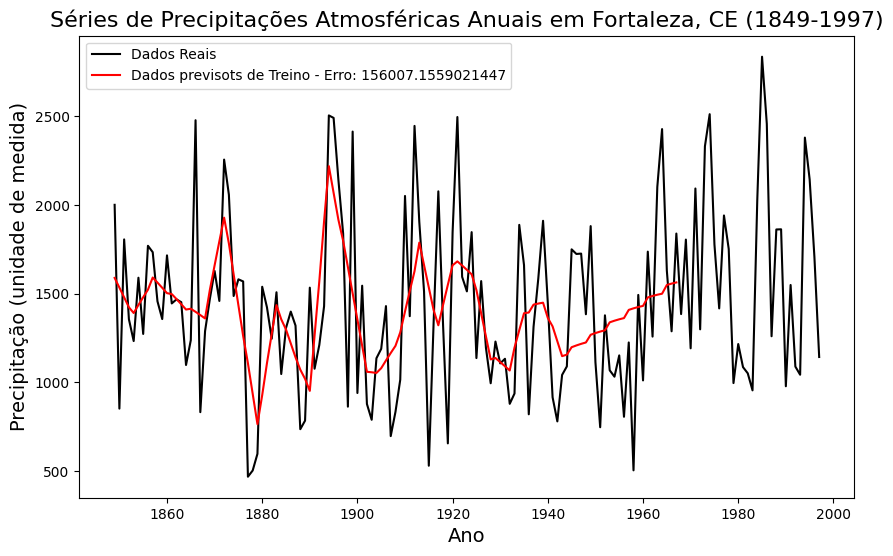

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the actual data
ax.plot(data1_prop['ds'], data1_prop['y'], label='Dados Reais', color='black')

# Plotting the fitted values
ax.plot(fitted['ds'], fitted['yhat'], label=f'Dados previsots de Treino - Erro: {mean_squared_error(train["y"], fitted["yhat"])}', color='red')

# Adding labels and legend
plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.legend()
plt.show()

In [ ]:
print('MSE TREINO', mean_squared_error(train['y'], fitted['yhat']))
print('RMSE TREINO', mean_squared_error(train['y'], fitted['yhat'])**(1/2))

MSE TREINO 156007.1559021447
RMSE TREINO 394.97741188850875


In [ ]:
forecast = model.predict(test)

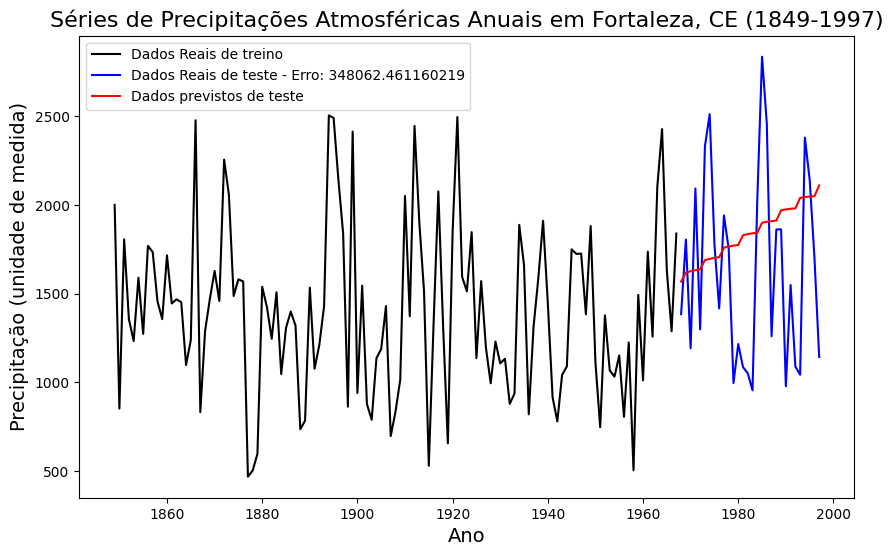

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
mean_squared_error(test['y'], forecast['yhat'])
ax.plot(train['ds'], train['y'], label='Dados Reais de treino', color='black')
ax.plot(test['ds'], test['y'], label=f'Dados Reais de teste - Erro: {mean_squared_error(test["y"], forecast["yhat"])}', color='blue')
ax.plot(forecast['ds'], forecast['yhat'], label='Dados previstos de teste', color='red')

# Adding labels and legend
plt.title('Séries de Precipitações Atmosféricas Anuais em Fortaleza, CE (1849-1997)', fontsize=16)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Precipitação (unidade de medida)', fontsize=14)
plt.legend()
plt.show()

In [ ]:
future = model.make_future_dataframe(periods=50,freq='Y', include_history=True)
future

,ds
0,1849-01-01
1,1850-01-01
2,1851-01-01
3,1852-01-01
4,1853-01-01
...,...
164,2012-12-31
165,2013-12-31
166,2014-12-31
167,2015-12-31


In [ ]:
forecast_final = model.predict(future)
forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
164,2012-12-31,2321.799659,-16621.003364,21762.699412
165,2013-12-31,2317.366973,-17218.108612,22440.455568
166,2014-12-31,2311.040036,-17337.903360,22810.770678
167,2015-12-31,2302.812959,-17699.714702,22973.506354
168,2016-12-31,2389.933740,-18994.207158,24068.698135


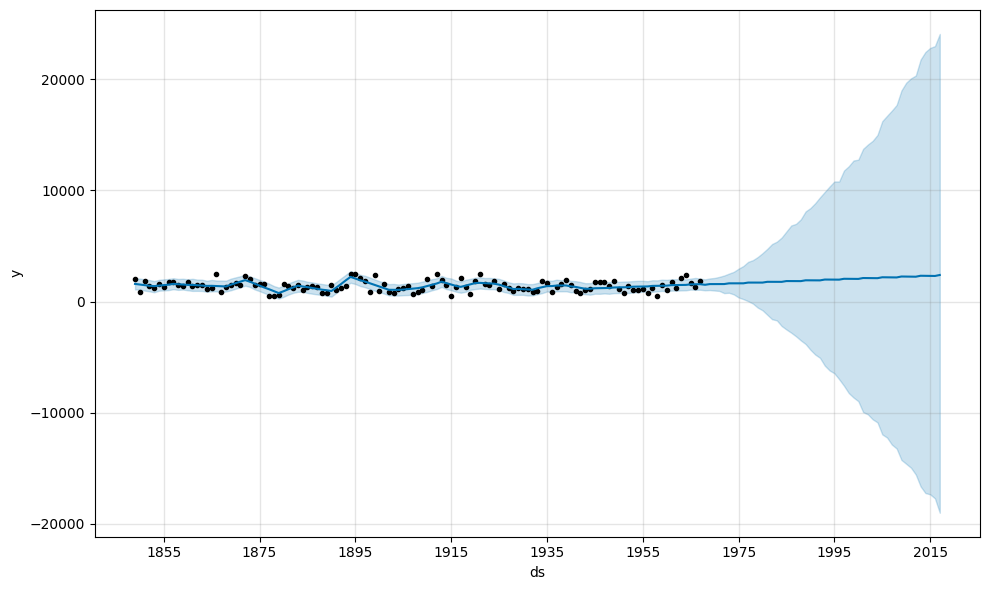

In [ ]:
fig1 = model.plot(forecast_final)